In [1]:
import pandas as pd
import sympy as sp
from sympy import symbols, Eq

In [4]:
data1 = pd.read_csv(r"C:\Users\imran.chamieh\Desktop\MethError\data\1_5000_row.csv")
data1_json = pd.read_json(r"C:\Users\imran.chamieh\Desktop\MethError\data\json\1_5000_rwo.json")
df = pd.read_csv(r"similarity_results.csv")

In [8]:
eq = Eq(sp.parse_expr("3*x+4"),sp.parse_expr( "5*y +3*a +4*x"))
variables = eq.rhs.free_symbols
print(variables)
for var in variables:
    coeff, rem = eq.lhs.as_independent(var)
    print(var,'->', coeff,'->', rem)

{y, a, x}
y -> 3*x + 4 -> 0
a -> 3*x + 4 -> 0
x -> 4 -> 3*x


In [1]:
from sympy import simplify, count_ops

def calculate_error_penalty(correct_eq, transformation_eq):
    """Calculate penalty based on algebraic difference between equations"""
    try:
        # Calculate algebraic difference
        diff = simplify(correct_eq.rhs - correct_eq.lhs - (transformation_eq.rhs - transformation_eq.lhs))
        
        if diff == 0:
            return 0  # No error
        
        # Calculate penalty based on error complexity
        return min(0.5, 0.1 * (count_ops(diff) + abs(diff.as_coefficients_dict()[1])))
    except:
        return 0.5  # Maximum penalty for unparseable differences

In [ ]:
import pandas as pd
import sympy as sp
from sympy import Eq, simplify, symbols, Add, S, count_ops
from itertools import combinations
import re
from difflib import SequenceMatcher
from functools import lru_cache
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from abc import ABC, abstractmethod
from typing import List, Tuple, Set, Dict
from sympy.parsing.latex import parse_latex
import logging

class EquationPreprocessor:
    """Handles preprocessing of equation strings"""
    _MULTIPLY_PATTERNS = [
    (re.compile(r'(\d)([a-zA-Z(])'), r'\1*\2'),
    (re.compile(r'([a-zA-Z])(\d)'), r'\1*\2',evaluate = False,evaluate = False,evaluate = False),
    (re.compile(r'([a-zA-Z])([a-zA-Z])'), r'\1*\2'),
    (re.compile(r'\)([a-zA-Z(])'), r')*\1'),
    (re.compile(r'([a-zA-Z)])(\()'), r'\1*\2'),
]

    def preprocess(self, expr_str: str) -> str:
        """Normalize and insert implicit multiplication operators"""
        expr_str = expr_str.replace('−', '-').strip()
        for pattern, replacement in self._MULTIPLY_PATTERNS:
            expr_str = pattern.sub(replacement, expr_str)
        return expr_str
        

class EquationParser:
    """Handles parsing and caching of equations"""
    def __init__(self, preprocessor: EquationPreprocessor):
        self.preprocessor = preprocessor

    @lru_cache(maxsize=128)
    def parse(self, eq_str: str) -> Tuple[Eq, Eq]:
        """Parse equation string into evaluated and raw forms"""
        try:
            lhs, rhs = map(str.strip, eq_str.split('=', 1))
        except ValueError:
            raise ValueError("Equation must contain exactly one '='")

        lhs_expr = self._parse_side(lhs)
        rhs_expr = self._parse_side(rhs)

        return (
            Eq(simplify(lhs_expr), simplify(rhs_expr)),
            Eq(lhs_expr, rhs_expr,  evaluate=False)
        )

    def _parse_side(self, side_str: str) -> sp.Expr:
        """Parse a single side of an equation"""
        return sp.parse_expr(
            self.preprocessor.preprocess(side_str),
            evaluate=False
        )

class RearrangementGenerator:
    """Generates algebraic rearrangements of equations"""
    def __init__(self, max_terms: int = 4):
        self.max_terms = max_terms
        self.logger = logging.getLogger(__name__)


    def generate(self, equation: Eq) -> Set[Eq]:
        """Generate all valid rearrangements of an equation"""
        canonical = simplify(equation.lhs - equation.rhs)
        rearrangements = set()

        rearrangements.update(self._generate_term_combinations(canonical))
        rearrangements.update(self._solve_for_variables(canonical))
        rearrangements.update(self._create_canonical_forms(canonical))
        rearrangements.update(self._convert_to_decimals(rearrangements))
        rearrangements.update(self.generate_all_transformations(equation))

        return rearrangements
    
    def _safe_update(self, target: set, source: set) -> None:
        """Safely add elements to target set"""
        try:
            target.update(source)
        except Exception as e:
            self.logger.warning(f"Failed to update set: {str(e)}")

    def _generate_term_combinations(self, expr: sp.Expr) -> Set[Eq]:
        """Generate term combinations with error handling"""
        rearrangements = set()
        try:
            terms = tuple(Add.make_args(expr))
            for k in range(min(len(terms), self.max_terms) + 1):
                for combo in combinations(terms, k):
                    try:
                        remaining = tuple(t for t in terms if t not in combo)
                        left, right = Add(*combo), -Add(*remaining)
                        rearrangements.update({
                            Eq(left, right), Eq(right, left),
                            Eq(-left, -right), Eq(-right, -left)
                        })
                    except Exception as e:
                        self.logger.debug(f"Skipping invalid combination: {str(e)}")
                        continue
        except Exception as e:
            self.logger.error(f"Term combination failed: {str(e)}")
        return rearrangements

    def _solve_for_variables(self, expr: sp.Expr) -> Set[Eq]:
        """Solve equation for variables with enhanced safety"""
        solutions = set()
        for var in expr.free_symbols:
            try:
                solution = sp.solve(expr, var, dict=True)
                if solution and isinstance(solution[0], dict):
                    sol_eq = Eq(var, solution[0][var])
                    solutions.add(sol_eq)
            except (NotImplementedError, TypeError, KeyError) as e:
                self.logger.debug(f"Skipping variable {var}: {str(e)}")
                continue
        return solutions

    def subtract_term(self, eq: Eq, term: sp.Expr) -> Eq:
        """Subtract a given term from both sides of an equation."""
        try:
            lhs_str =""
            rhs_str = ""
            term_str = str(term)
            term_str_sign = term_str[0]
            # remove the first character if it is a negative or positive sign
            if term_str_sign == '-' or term_str_sign == '+':
                term_str = term_str[1:]

            # initialize the equation string
            eq_str = Eq(eq.lhs, eq.rhs)
            eq_ter2 = Eq(eq.lhs, eq.rhs)
            
            # check if term is scalar 
            
            if not term.is_Number :
                if term in eq.lhs.as_ordered_terms() :

                    temp_eq = Eq(term, 0)
                    term_sign = temp_eq.lhs.coeff(term)

                    lhs_str = str(eq.lhs - term)
                    rhs_str = str(eq.rhs)
                    if term_sign > 0 or term_str_sign == '+':
                        
                        rhs_str = rhs_str.__add__(' - ').__add__(term_str)
                    elif term_sign < 0 or term_str_sign == '-':
                        rhs_str = rhs_str.__add__(' + ').__add__(term_str)
                    else:
                        rhs_str = rhs_str.__add__(' - ').__add__(term_str)
                
                else:

                    term_sign = eq.rhs.coeff(term)

                    rhs_str = str(eq.rhs - term)
                    lhs_str = str(eq.lhs)

                    if term_sign > 0 or term_str_sign == '+':

                        lhs_str = lhs_str.__add__(' - ').__add__(term_str)
                    elif term_sign < 0 or term_str_sign == '-':
                        lhs_str = lhs_str.__add__(' + ').__add__(term_str)
                    else:
                        lhs_str = lhs_str.__add__(' - ').__add__(term_str)

                eq_str = Eq(sp.parse_expr(lhs_str, evaluate=False), sp.parse_expr(rhs_str, evaluate=False))
                eq_ter2 = Eq(sp.parse_expr(lhs_str), sp.parse_expr(rhs_str))

            # remove term_str from the lhs_str
            # Add - term_str to the rhs_str
            #print(f"lhs_str: {lhs_str}")
            
            eq = Eq(eq.lhs - term, eq.rhs - term)
            # return both the string and the equation
            return eq, eq_str, eq_ter2
        except Exception as e:
            self.logger.debug(f"Subtraction skipped: {str(e)}")
            return eq


    def divide_equation_by_term(self, eq: Eq) -> Eq:
        """Safe division with zero-check"""
        try:
            variable = next(iter(eq.lhs.free_symbols), None)
            if variable is None:
                return eq
                
            coeff = eq.lhs.coeff(variable)
            if coeff == 0:
                raise ValueError("Zero coefficient")
                
            return Eq(eq.lhs/coeff, eq.rhs/coeff)
        except Exception as e:
            self.logger.debug(f"Division skipped: {str(e)}")
            return eq

    def transformation_sequence(self, eq: Eq, terms: List[sp.Expr], index: int) -> Set[Eq]:
        """Robust transformation sequence with error isolation"""
        transformations = set()
        try:
            if index >= len(terms):
                return transformations
                
            term = terms[index]
            eq1, eq2 = self.subtract_term(eq, term)
            transformations.add(eq1)
            transformations.add(eq2)
            
            # Add simplified version
            try:
                transformations.add(simplify(eq1))
            except Exception as e:
                self.logger.debug(f"Simplification failed: {str(e)}")

            # Attempt division
            try:
                if len(eq1.lhs.as_ordered_terms()) == 1:
                # check if the term is an integer then skip the division
                    if not eq1.lhs.as_ordered_terms()[0].is_integer:
                        eq1_div = self.divide_equation_by_term(eq1)
                        #print(f"eq1_div: {eq1_div}")
                        eq1_div_simpified = simplify(eq1_div)
                        #print(f"eq1_div_simpified: {eq1_div_simpified}")

                        transformations.add(eq1_div)   
                        transformations.add(eq1_div_simpified)
                    

                # Now subtract each of the other terms from eq1.
                for j, term in enumerate(terms):
                    if j == index:
                        continue
                    eq_sub1, eq_sub2 = self.subtract_term(eq1, term)
                    #print(f"eq_sub: {eq_sub1}")
                    #print(f"eq_sub2: {eq_sub2}")
                    #print(f"simplify eq_sub: {simplify(eq_sub)}")
                    transformations.add(eq_sub1)
                    transformations.add(eq_sub2)
                    transformations.add(simplify(eq_sub1))
                    # Check if there is only one term on the left side
                    if len(eq_sub1.lhs.as_ordered_terms()) == 1 and not eq_sub1.lhs.as_ordered_terms()[0].is_integer:
                        eq1_div = self.divide_equation_by_term(eq_sub1)
                        transformations.add(eq1_div)
                        transformations.add(simplify(eq1_div))
                        #print(f"eq1_div: {eq1_div}")

                    if len(eq_sub2.lhs.as_ordered_terms()) == 1 and not eq_sub2.lhs.as_ordered_terms()[0].is_integer:
                        eq2_div = self.divide_equation_by_term(eq_sub2)
                        transformations.add(eq2_div)
                        transformations.add(simplify(eq2_div))
                        #print(f"eq2_div: {eq2_div}")
                return transformations


            except Exception as e:
                self.logger.warning(f"Transformation sequence aborted: {str(e)}")
        except Exception as e:
            self.logger.error(f"Transformation sequence failed: {str(e)}")
            return transformations
            
        return transformations

    def generate_all_transformations(self, eq: Eq) -> Set[Eq]:
        """Fault-tolerant transformation generator"""
        transformations = set()
        try:
            terms = self.get_terms(eq)
            for i in range(len(terms)):
                try:
                    transforms = self.transformation_sequence(eq, terms, i)
                    transformations.update(transforms)
                except Exception as e:
                    self.logger.debug(f"Skipping term {i}: {str(e)}")
                    continue
        except Exception as e:
            self.logger.error(f"Transformation generation failed: {str(e)}")
            
        return transformations

    def get_terms(self, eq: Eq) -> List[sp.Expr]:
        """Safe term extraction"""
        try:
            return Add.make_args(eq.lhs) + Add.make_args(eq.rhs)
        except Exception as e:
            self.logger.error(f"Term extraction failed: {str(e)}")
            return []
    


    def _create_canonical_forms(self, expr: sp.Expr) -> Set[Eq]:
        """Create standard canonical forms"""
        return {Eq(expr, 0), Eq(0, expr), Eq(-expr, 0), Eq(0, -expr)}

    def _convert_to_decimals(self, equations: Set[Eq]) -> Set[Eq]:
        """Create decimal representations of equations with exactly two decimals."""
        decimal_equations = set()
        for eq in equations:
            try:
                lhs_val = sp.N(eq.lhs)
                rhs_val = sp.N(eq.rhs)
                # Format the evaluated expressions to two decimals
                lhs_str = f"{lhs_val:.2f}"
                rhs_str = f"{rhs_val:.2f}"
                # Convert back to a sympy expression (Float)
                new_eq = Eq(sp.sympify(lhs_str), sp.sympify(rhs_str))
                decimal_equations.add(new_eq)
            except Exception as e:
                # If conversion fails, simply skip this equation.
                continue
        return decimal_equations




In [13]:

class SimilarityStrategy(ABC):
    """Abstract base class for similarity strategies"""
    @abstractmethod
    def calculate(self, eq1: Eq, eq2: Eq) -> float:
        pass

class StructuralSimilarity(SimilarityStrategy):
    """Structural similarity using sequence matching"""
    @lru_cache(maxsize=1024)
    def _structural_ratio(self, a: str, b: str) -> float:
        return SequenceMatcher(None, a, b).ratio()

    def calculate(self, eq1: Eq, eq2: Eq) -> float:
        try:
            canon1 = simplify(eq1.lhs - eq1.rhs)
            canon2 = simplify(eq2.lhs - eq2.rhs)
             # Handle cases where simplify() returns True or False
            if isinstance(canon1, bool):
                canon1 = sp.S.Zero
            if isinstance(canon2, bool):
                canon2 = sp.S.Zero
            base_score = np.mean([
                self._structural_ratio(sp.srepr(eq1.lhs), sp.srepr(eq2.lhs)),
                self._structural_ratio(sp.srepr(eq1.rhs), sp.srepr(eq2.rhs)),
                self._structural_ratio(sp.srepr(canon1), sp.srepr(canon2))
            ])

            base_score2 = np.mean([
                self._structural_ratio(sp.srepr(eq1.rhs), sp.srepr(eq2.lhs)),
                self._structural_ratio(sp.srepr(eq1.lhs), sp.srepr(eq2.rhs)),
                self._structural_ratio(sp.srepr(canon1), sp.srepr(canon2))
            ])
            
        
        
            return max(base_score, base_score2)
        except Exception as e:
            logging.error(f"Structural similarity failed: {str(e)}")
            return 0



In [14]:
def enhanced_similarity(correct_eq, transformation_eq, base_similarity):
    """Augment similarity score with error analysis"""
    penalty = calculate_error_penalty(correct_eq, transformation_eq)
    
    # Combine base similarity with error penalty
    adjusted_score = base_similarity * (1 - penalty)
    
    # Add bonus for exact match after error correction
    if penalty == 0:
        adjusted_score = min(1.0, adjusted_score + 0.1)
        
    return round(adjusted_score, 2)

def analyze_transformation(original_eq, transformation_eq):
    """Full analysis pipeline with error detection"""
    results = []
    
    # Generate all valid rearrangements
    generator = RearrangementGenerator()
    preprocessor = EquationPreprocessor()
    parser = EquationParser(preprocessor)
    simi_strategy = SimilarityStrategy()
    base_simi = StructuralSimilarity()
    all_rearrangements = generator.generate(parser(original_eq))
    
    # Calculate similarity with error analysis
    for correct_form in all_rearrangements:
        base_score = base_simi.calculate(correct_form, transformation_eq)
        enhanced_score = enhanced_similarity(correct_form, transformation_eq, base_score)
        
        results.append({
            'correct_form': correct_form,
            'base_similarity': base_score,
            'enhanced_similarity': enhanced_score,
            'error_term': get_error_term(correct_form, transformation_eq)
        })
    
    return sorted(results, key=lambda x: x['enhanced_similarity'], reverse=True)

def get_error_term(correct_eq, transformation_eq):
    """Identify the error term between equations"""
    try:
        diff = simplify(correct_eq.rhs - correct_eq.lhs - (transformation_eq.rhs - transformation_eq.lhs))
        return diff if diff != 0 else None
    except:
        return "Unknown error"

In [63]:
lhs_org = sp.parse_expr("-3*x+4*y +4*x- 6", evaluate=False)
rhs_org = sp.sympify("y")
original = Eq(lhs_org, rhs_org)
terms = lhs_org.as_ordered_terms()
print(f"Original: {terms}")

terms[0].as_coefficient(1)

Original: [-3*x, 4*x, 4*y, -1*6]


-3*x

In [72]:
tuple(Add.make_args(lhs_org))
print(f"lhs_org: {lhs_org}")
# subract rhs_org from lhs_org without simplification
lhs_str = str(lhs_org - rhs_org)
print(f"lhs_str: {lhs_str}")
#canonical = sp.parse_expr(str(lhs_org) - str(rhs_org), evaluate=False)
print(f"canonical: {canonical}")

lhs_org: -3*x + 4*x + 4*y - 1*6
lhs_str: x + 3*y - 6
canonical: x + 3*y - 1*6


In [ ]:
x, y = sp.symbols('x y')

# Define the equation
equation = sp.Eq(4*x+2,4*x-y)

# Extract terms from LHS and subtract RHS terms manually
lhs_terms = equation.lhs.args if equation.lhs.func == sp.Add else (equation.lhs,)
rhs_terms = equation.rhs.args if equation.rhs.func == sp.Add else (equation.rhs,)

# Combine terms: LHS - RHS = LHS + (-RHS_terms)
unevaluated_terms = list(lhs_terms) + [-term for term in rhs_terms]

# Build the unevaluated expression
canonical_expr = sp.Add(*unevaluated_terms, evaluate=False)

# Form the equation
canonical_eq = sp.Eq(canonical_expr, 0)

print(canonical_eq)  # Output: Eq(3*x + 2 - y - 3*x, 0)

Eq(-4*x - 4*x + y + 2, 0)


In [66]:
terms2 =  tuple(Add.make_args(lhs_org))
# import premutations
from itertools import permutations
perm = permutations(terms2, 2)
comp  = combinations(terms2, 3)
for c in comp:
    print(c)

(-3*x, 4*y, 4*x)
(-3*x, 4*y, -1*6)
(-3*x, 4*x, -1*6)
(4*y, 4*x, -1*6)


In [15]:
import sympy as sp
from itertools import combinations
from typing import Set

def _generate_term_combinations(expr: sp.Expr) -> Set[sp.Eq]:
    """Generate term combinations without combining like terms."""
    rearrangements = set()
    terms = sp.Add.make_args(expr)
    for k in range(len(terms) + 1):
        for combo in combinations(terms, k):
            # Split into selected (combo) and remaining terms
            remaining = [t for t in terms if t not in combo]
            # Construct left and right without evaluation
            left = sp.Add(*combo, evaluate=False)
            right = sp.Add(*[-term for term in remaining], evaluate=False)
            # Add all equation permutations
            rearrangements.update({
                sp.Eq(left, right), 
                sp.Eq(right, left),
                sp.Eq(-left, -right), 
                sp.Eq(-right, -left)
            })
    return rearrangements

# Example usage
r, s, x,y = sp.symbols('r s x y')
lhs_org = sp.parse_expr(" r - 4*s - 4*s + 2", evaluate=False)
print("Outside class - extracted terms:", lhs_org.args)


expr = r - 4*s - 4*s + 2
equations = _generate_term_combinations(lhs_org)
print(equations)
for i, eq in enumerate(equations):
    print(i, eq)

Outside class - extracted terms: (r, -4*s, -4*s, 2)
{Eq(0, r - 8*s + 2), Eq(-2, r - 8*s), Eq(-r + 4*s + 4*s, 2), Eq(4*s, r + 2), Eq(0, r - 4*s + 2), Eq(-r - 2, -8*s), Eq(r - 4*s - 4*s, -2), Eq(-4*s, -r - 2), Eq(4*s - 2, r), Eq(2, -r + 4*s), Eq(2 - 8*s, -r), Eq(2, -r + 8*s), Eq(8*s - 2, r), Eq(r - 8*s + 2, 0), Eq(4*s + 4*s - 2, r), Eq(r - 4*s, -2), Eq(-8*s, -r - 2), Eq(-r, -4*s - 4*s + 2), Eq(-r + 8*s - 2, 0), Eq(-r + 4*s + 4*s - 2, 0), Eq(2 - 4*s, -r), Eq(r - 4*s - 4*s + 2, 0), Eq(-r - 2, -4*s - 4*s), Eq(0, -r + 4*s - 2), Eq(0, -r + 8*s - 2), Eq(-r + 4*s - 2, 0), Eq(0, -r + 4*s + 4*s - 2), Eq(-r, 2 - 4*s), Eq(4*s + 4*s, r + 2), Eq(-r + 4*s, 2), Eq(-r - 2, -4*s), Eq(r, 4*s - 2), Eq(-r + 8*s, 2), Eq(2, -r + 4*s + 4*s), Eq(-r, 2 - 8*s), Eq(-2, r - 4*s - 4*s), Eq(r - 4*s + 2, 0), Eq(r, 8*s - 2), Eq(0, r - 4*s - 4*s + 2), Eq(r + 2, 4*s), Eq(r + 2, 8*s), Eq(r + 2, 4*s + 4*s), Eq(-4*s - 4*s + 2, -r), Eq(-2, r - 4*s), Eq(r, 4*s + 4*s - 2), Eq(r - 8*s, -2), Eq(8*s, r + 2), Eq(-4*s - 4*s, -r - 2

In [16]:
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
from itertools import combinations
from typing import Set
from sympy import Eq

class RearrangementGenerator:
    """Generates algebraic rearrangements of equations"""
    def __init__(self, max_terms: int = 4):
        self.max_terms = max_terms

    def generate(self, equation: Eq) -> Set[Eq]:
        """Generate rearrangements without term simplification"""
        # Ensure equation sides are not simplified
        lhs = parse_expr(str(equation.lhs), evaluate=False)
        rhs = parse_expr(str(equation.rhs), evaluate=False)
        equation = Eq(lhs, rhs, evaluate=False)
        
        # Manually subtract terms without evaluation
        lhs_terms = lhs.args if lhs.func == sp.Add else (lhs,)
        rhs_terms = rhs.args if rhs.func == sp.Add else (rhs,)
        unevaluated_terms = list(lhs_terms) + [-term for term in rhs_terms]
        canonical_expr = sp.Add(*unevaluated_terms, evaluate=False)
        
        # Generate term combinations
        rearrangements = self._generate_term_combinations(canonical_expr)
        return rearrangements

    def _generate_term_combinations(self, expr: sp.Expr) -> Set[Eq]:
        """Generate term combinations without combining terms"""
        rearrangements = set()
        terms = sp.Add.make_args(expr)
        for k in range(len(terms) + 1):
            for combo in combinations(terms, k):
                remaining = [t for t in terms if t not in combo]
                left = sp.Add(*combo, evaluate=False)
                right = sp.Add(*[-term for term in remaining], evaluate=False)
                rearrangements.update({
                    Eq(left, right), Eq(right, left),
                    Eq(-left, -right), Eq(-right, -left)
                })
        return rearrangements

In [ ]:
equation_str = "3*c*x*z*Y=-1/4*(-w)/2 + 1/2"
lhs_str, rhs_str = equation_str.split('=')
lhs = parse_expr(lhs_str.strip(), evaluate=False)
rhs = parse_expr(rhs_str.strip(), evaluate=False)
equation = Eq(lhs, rhs, evaluate=True)
variable = next(iter(equation.lhs.free_symbols), None)
if variable is None:
   print("no variable found")                
coeff = equation.lhs.coeff(variable)
print(f"variable: {variable}")
print(f"coeff: {coeff}")
print(equation.free_symbols)


variable: x
coeff: 3*Y*c*z
{w, x, Y, z, c}


: 

In [11]:
import sympy as sp
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sympy import Eq,simplify
from typing import List
import re
import logging
from difflib import SequenceMatcher

# Define symbols
x, a = sp.symbols('x a')

# Given equations
eq1_l, eq1_r = "c" , "m/4 - 1/4" 
eq2_l, eq2_r = "c", "(m + 1)/4"       # Rearranging second equation to the left-hand side

# Convert to standard form (move everything to one side)
std_eq1 =Eq(sp.parse_expr(eq1_l), sp.parse_expr(eq1_r), evaluate=False)  # Multiply by 'a' to clear the fraction
std_eq2 = Eq(sp.parse_expr(eq2_l,
            evaluate=False), sp.parse_expr(eq2_r,
            evaluate=False), evaluate=False)

def tokenize( expr: sp.Expr) -> List[str]:
        return re.findall(r'[a-zA-Z]+|\d+|[\+\-\*/\^()]', sp.srepr(expr))

def calculate( eq1: Eq, eq2: Eq) -> float:
        try:
            tokens1 = tokenize(eq1.lhs) + tokenize(eq1.rhs)
            tokens2 = tokenize(eq2.lhs) + tokenize(eq2.rhs)

            # Prevent boolean issues
            if isinstance(tokens1, bool) or isinstance(tokens2, bool):
                return 0
            all_tokens = list(set(tokens1 + tokens2))
            vec1 = np.array([tokens1.count(t) for t in all_tokens])
            vec2 = np.array([tokens2.count(t) for t in all_tokens])

            return cosine_similarity([vec1], [vec2])[0][0]
        except Exception as e:
            logging.error(f"Cosine similarity failed: {str(e)}")
            return 0
        
def _structural_ratio( a: str, b: str) -> float:
        return SequenceMatcher(None, a, b).ratio()

def calculate2( eq1: Eq, eq2: Eq) -> float:
        try:
            canon1 = simplify(eq1.lhs - eq1.rhs)
            canon2 = simplify(eq2.lhs - eq2.rhs)
             # Handle cases where simplify() returns True or False
            if isinstance(canon1, bool):
                canon1 = sp.S.Zero
            if isinstance(canon2, bool):
                canon2 = sp.S.Zero
            base_score = np.mean([
                _structural_ratio(sp.srepr(eq1.lhs), sp.srepr(eq2.lhs)),
                _structural_ratio(sp.srepr(eq1.rhs), sp.srepr(eq2.rhs)),
                _structural_ratio(sp.srepr(canon1), sp.srepr(canon2))
            ])

            base_score2 = np.mean([
                _structural_ratio(sp.srepr(eq1.rhs), sp.srepr(eq2.lhs)),
                _structural_ratio(sp.srepr(eq1.lhs), sp.srepr(eq2.rhs)),
                _structural_ratio(sp.srepr(canon1), sp.srepr(canon2))
            ])
            return max(base_score, base_score2)
        except Exception as e:
            logging.error(f"Structural similarity failed: {str(e)}")
            return 0



# Compute cosine similarity
cosine_sim = calculate( std_eq1, std_eq2)
st_sim = calculate2(std_eq1, std_eq2)

# Display results
print("Equation 1:", std_eq1)
print("Equation 2:", std_eq2)

print(f"Cosine Similarity: {cosine_sim:.4f}")
print(f"struc Similarity: {st_sim:.4f}")


Equation 1: Eq(c, m/4 - 1/4)
Equation 2: Eq(c, (m + 1)/4)
Cosine Similarity: 0.9336
struc Similarity: 0.7899


In [13]:
import sympy as sp
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sympy import Eq,simplify
from typing import List
import re
import logging
from difflib import SequenceMatcher

# Define symbols
x, a = sp.symbols('x a')

# Given equations
eq1_l, eq1_r = "c" , "m/4 - 1/4" 
eq2_l, eq2_r = "c+ 2*c", "(m + 1)/4 + m"       # Rearranging second equation to the left-hand side

# Convert to standard form (move everything to one side)
std_eq1 =Eq(sp.parse_expr(eq1_l), sp.parse_expr(eq1_r), evaluate=False)  # Multiply by 'a' to clear the fraction
std_eq2 = Eq(sp.parse_expr(eq2_l, evaluate=False), sp.parse_expr(eq2_r, evaluate=False), evaluate=False)

std_eq22 = Eq(sp.parse_expr(eq2_l), sp.parse_expr(eq2_r), evaluate=False)

std_eq222 = Eq(sp.parse_expr(eq2_l), sp.parse_expr(eq2_r))
std_eq2222 = Eq(sp.simplify(eq2_l), sp.simplify(eq2_r))
std_eq22222 = Eq(sp.simplify(eq2_l), sp.simplify(eq2_r), evaluate=False)

print(f"std_eq2: {std_eq2}")
print(f"std_eq22: {std_eq22}")

print(f"std_eq222: {std_eq222}")

print(f"std_eq2222: {std_eq2222}")
print(f"std_eq22222: {std_eq22222}")




std_eq2: Eq(c + 2*c, m + (m + 1)/4)
std_eq22: Eq(3*c, 5*m/4 + 1/4)
std_eq222: Eq(3*c, 5*m/4 + 1/4)
std_eq2222: Eq(3*c, 5*m/4 + 1/4)
std_eq22222: Eq(3*c, 5*m/4 + 1/4)


In [ ]:
import sympy as sp

# Define the equation as a string to preserve terms
equation_str = "c=-1/4*(-w)/2 + 1/2"
lhs_str, rhs_str = equation_str.split('=')
lhs = sp.parse_expr(lhs_str.strip(), evaluate=False)
rhs = sp.parse_expr(rhs_str.strip(), evaluate=False)
mk_args = sp.Add.make_args(rhs) + sp.Add.make_args(lhs)

print(mk_args)
print(sp.simplify(mk_args[0]))



(-1*(-w)/(4*2), 1/2, c)
w/8


In [3]:
from sympy import Eq, symbols, simplify
import re

def remove_duplicate_equations(equations):
    unique_equations = set()
    cleaned_equations = []
    
    for eq in equations:
        normalized_eq = eq.replace(" ", "").replace("*1", "").replace("+0", "").replace("-0", "")
        if normalized_eq not in unique_equations:
            unique_equations.add(normalized_eq)
            cleaned_equations.append(eq)  # Keep original formatting

    return cleaned_equations

# Example usage
equations = [
"r - 8*s + 1*2 = -2 + 2 "
,"2 = -r + 8*s "
,"-8*s = -r - 2 "
,"2.0 - 8.0*s = -r "
,"8*s - 2 = r "
,"8*s = r + 2 "
,"r/8 + 1/4 = s "
,"r = 8.0*s - 2.0 "
,"r + 2.0 = 8.0*s "
,"r - 8*s + 2 = -2 + 2 "
,"0 = -r + 8*s - 2 "
,"-r + 8.0*s - 2.0 = 0 "
,"r = 8*s - 2 "
,"s = (r + 2)/8 "
,"2.0 = -r + 8.0*s "
,"0 = r - 8*s + 2 "
,"s = r/8 + 1/4 "
,"-r = 2 - 8*s "
,"0 = r - 8*s + 2 "
,"r = 8*s - 2 "
,"-r + 8.0*s = 2.0 "
,"r - 8*s + 2 = 0 "
,"8.0*s = r + 2.0 "
,"2 = -r + 8*s - 2 + 2 "
,"-r - 2.0 = -8.0*s "
,"r - 8.0*s = -2.0 "
,"-8.0*s = -r - 2.0 "
,"2 - 8*s = -r "
,"8*s - 1*1*2 = r "
,"-2 = r - 8*s "
,"-r - 2 = -8*s "
,"2 - 8*s = -r "
,"8*s = r + 2 "
,"0.13*r + 0.25 = s "
,"r + 0 = 8*s - 1*2 "
,"8.0*s - 2.0 = r "
,"-2 = r - 8*s "
,"-r + 8*s - 2 = 0 "
,"0 = -r + 8.0*s - 2.0 "
,"0 = -r + 8*s - 1*2 "
,"r - 8.0*s + 2.0 = 0 "
,"r = (2 - 8*s)/(-1) "
,"-r + 8*s = 2 "
,"r - 8*s + 2 = 0 "
,"-r - 2 = -8*s "
,"-r = 2.0 - 8.0*s "
,"s = 0.13*r + 0.25 "
,"r - 8*s = -2 "
,"r + 2 = 8*s "
,"0 = -r + 8*s - 2 "
,"r - 8.0*s + 2.0 = 0E-110 "
,"2 = -r + 8*s - 1*1*2 + 2 "
,"8*s - 2 = r "
,"r - 8*s + 1*2 = 0 "
,"-8*s + 1*2 = -r - 1*2 + 2 "
,"-r = 2 - 8*s "
,"r - 8*s + 2 = 0 "
,"-8*s = -r - 2 "
,"0 = -r + 8*s - 2 "
,"r = 8*s - 1*1*2 "
,"-2.0 = r - 8.0*s "
,"-r + 8*s - 2 = 0 "
,"0 = r - 8.0*s + 2.0 "
,"-r + 8*s - 2 = 0 "
,"0 = -r + 8*s - 2 "
,"r + 0 = 8*s - 2 "
,"0 = r - 8*s + 2 "
,"-r + 8*s = 2 "
,"r - 8*s = -2 "
,"r + 2 = 8*s "
,"s = (-r - 1*2)/(-8) "
,"0 + 1*2 = -r + 8*s - 2 + 2 "
,"2 - 8*s = -r - 2 + 2 "
,"2 = -r + 8*s "
,"2 = -r + 8*s - 2 + 2"
]

cleaned_equations = remove_duplicate_equations(equations)
print(len(cleaned_equations))
print(len(equations))


51
75


In [7]:
eqs = [
"2 = -r + 8*s" 
,"-8*s = -r - 2" 
,"-r = -4*s - 4*s + 2" 
,"r - 4.0*s = 4.0*s - 2.0" 
,"r + 2.0 = 8.0*s" 
,"r = 8*s - 2" 
,"2.0 = -r + 8.0*s" 
,"-2*4*s = -r - 2" 
,"0.25*r - s + 0.5 = s" 
,"r = 4*s + 4*s - 2" 
,"0 = r - 4*s - 4*s + 2" 
,"8.0*s = r + 2.0" 
,"0 = r - 4*s - 4*s + 2" 
,"2 - 4*s = -r + 4*s" 
,"-4*s - 4*s + 4*s + 2 = -r + 4*s" 
,"r - 2*4*s + 2 = 0" 
,"0 = -r + 8.0*s - 2.0" 
,"2 = -r + 4*s + 4*s" 
,"-r + 8*s = 2" 
,"r - 4*s - 4*s + 2 = 0" 
,"0 = -r + 4*s + 4*s - 2" 
,"r - 4*s - 4*s = -2" 
,"0 = -r + 4*s + 4*s - 2" 
,"r - 4*s + 2 = 4*s" 
,"s = r/4 - s + 1/2" 
,"2.0 - 8.0*s = -r" 
,"4*s + 4*s - 2 = r" 
,"r = 8.0*s - 2.0" 
,"-r - 2 = -4*s - 4*s" 
,"-r + 8.0*s - 2.0 = 0" 
,"0 = r - 8*s + 2" 
,"s = r/8 + 1/4" 
,"-4*s - 4*s + 2 = -r" 
,"-r - 2.0 = -8.0*s" 
,"r = (-4*s - 4*s + 2)/(-1)" 
,"-2 = r - 4*s - 4*s" 
,"r - 4*s = 4*s - 2" 
,"r + 2 = 4*s + 4*s" 
,"-r + 8*s - 2 = 0" 
,"r - 8.0*s + 2.0 = 0" 
,"s = (-r + 4*s - 1*2)/(-4)" 
,"-r + 4*s + 4*s - 2 = 0" 
,"2 = -r + 4*s + 4*s" 
,"2.0 - 4.0*s = -r + 4.0*s" 
,"2 = -r + 4*s + 4*s" 
,"r - 8*s = -2" 
,"s = (-r - 1*2)/(-8)" 
,"(-r - 1*2)/(-8) = s" 
,"-4*s - 4*s = -r - 2" 
,"-2 = r - 4*s - 4*s" 
,"r/4 - s + 1/2 = s" 
,"-2*4*s + 4*s + 2 = -r + 4*s" 
,"8*s = r + 2" 
,"r/8 + 1/4 = s" 
,"s = 0.25*r - s + 0.5" 
,"-4*s - 4*s + 2 = -r" 
,"s = (r + 2)/8" 
,"r - 4*s + 2 = 4*s" 
,"-r = -4*s - 4*s + 2" 
,"-r + 8.0*s = 2.0" 
,"r - 4*s - 1*4*s + 2 = 0" 
,"r - 8.0*s = -2.0" 
,"2 - 8*s = -r" 
,"-2 = r - 8*s" 
,"-r - 2 = -8*s" 
,"r - 4*s - 4*s + 2 = 0" 
,"4*s + 4*s - 2 = r" 
,"r = (2 - 8*s)/(-1)" 
,"r - 4*s - 4*s + 2 = 0" 
,"-r + 4*s + 4*s = 2" 
,"-r + 4*s + 4*s - 2 = 0" 
,"2 - 4*s = -r + 4*s" 
,"-r = 2 - 8*s" 
,"4*s + 4*s = r + 2" 
,"0 = -r + 8*s - 2" 
,"r = 4*s + 4*s - 2" 
,"r - 4*s + 4*s + 2 = 8*s" 
,"8*s - 2 = r" 
,"r - 4*s - 4*s + 2 = 0" 
,"r - 8*s + 2 = 0" 
,"-8.0*s = -r - 2.0" 
,"2 - 4*s = -r + 4*s" 
,"r - 4*s - 4*s = -2" 
,"0.13*r + 0.25 = s" 
,"8.0*s - 2.0 = r" 
,"-r = 2.0 - 8.0*s" 
,"s = 0.13*r + 0.25" 
,"r + 2 = 8*s" 
,"-4*s = -r + 4*s - 2" 
,"r - 4.0*s + 2.0 = 4.0*s" 
,"-2.0 = r - 8.0*s" 
,"r - 1*4*s = 4*s - 2" 
,"0 = r - 8.0*s + 2.0" 
,"-4.0*s = -r + 4.0*s - 2.0" 
,"r - 1*4*s + 4*s + 2 = 8*s" 
,"-r + 4*s + 4*s = 2" 
,"s = 0.25*r - 1.0*s + 0.5"
]
cleaned_equations = remove_duplicate_equations(eqs)
print(len(cleaned_equations))
print(len(eqs))

79
97


In [10]:
eqs2 = [
"-4*s = -r + 4*s - 1*2" 
,"-(-1)*r - 4*s = -r - (-1)*r + 4*s - 1*2" 
,"-4*s - 4*s + 2 = -r - 4*s + 4*s" 
,"-4*s + 0 = -r + 4*s - 2" 
,"-4*s + 0 = -r - 4*s + 8*s - 1*2" 
,"-4*s = -r + 4*s - 2" 
,"-4*s - (-1)*4*s + 2 = -r + 4*s - (-1)*4*s" 
,"-(-1)*r - 4*s + 2 = 4*s" 
,"s = r/8 + 1/4" 
,"r = 4*s - (-1)*4*s - 1*2" 
,"0 = -r + 8*s - 1*2" 
,"r = 8*s - 2" 
,"r - 4*s - (-1)*4*s = 4*s - (-1)*4*s - 1*2" 
,"r = 8*s - 1*2" 
,"r - 4*s = 4*s - 2" 
,"s = r/4 - s + 1/2" 
,"2 - 4*s = -r + 4*s" 
,"-8*s - 1*2 + 2 = -r - 1*2" 
,"r - 4*s + 2 = 4*s" 
,"2 = -r + 8*s" 
,"-(-1)*r + 0 = 8*s - 2" 
,"-8*s - (-1)*4*s + 2 = -r + 4*s" 
,"-(-1)*r - 4*s = 4*s - 2" 
,"r - 4*s - 1*2 + 2 = 4*s - 1*2" 
,"-8*s = -r - 1*2" 
,"2 = -r + 4*s - (-1)*4*s" 
,"-8*s - (-1)*4*s = -r + 4*s - 2" 
,"r - 1*2 + 2 = 8*s - 1*2" 
,"-8*s = -r - 2" 
,"2 - 8*s = -r" 
,"0 = -r + 4*s - (-1)*4*s - 1*2" 
,"2 - 4*s = -r + 4*s" 
,"-4*s - (-1)*4*s = -r + 4*s - (-1)*4*s - 1*2" 
,"-8*s - (-1)*4*s = -r - (-1)*4*s - 1*2" 
,"r - 4*s - (-1)*4*s + 2 = 4*s - (-1)*4*s" 
,"r - 4*s = -4*s + 8*s - 1*2" 
,"r + 2 = 4*s - (-1)*4*s" 
,"-(-1)*r - 4*s + 2 = -r - (-1)*r + 4*s" 
,"-8*s - (-1)*4*s + 2 = -r - (-1)*4*s" 
,"r + 2 = 8*s" 
,"-4*s - 4*s + 2 = -r" 
,"r - 4*s = 4*s - 2" 
,"-4*s - 1*2 + 2 = -r + 4*s - 1*2" 
,"r - 4*s = 4*s - 1*2" 
,"2 - 1*2 = -r + 8*s - 1*2" 
,"-(-1)*r + 0 = -r - (-1)*r + 8*s - 1*2" 
,"0 = -r + 8*s - 2"
]
def find_unique_equations(list1, list2):
    # Normalize equations by removing spaces and simplifying unnecessary multiplications/additions
    def normalize(eq):
        return eq.replace(" ", "").replace("*1", "").replace("+0", "").replace("-0", "")
    
    normalized_set2 = {eq for eq in list2}
    
    unique_equations = [eq for eq in list1 if eq not in normalized_set2]
    
    return unique_equations


unique_equations = find_unique_equations(eqs2, eqs)
print(len(unique_equations))
print("Equations unique to list1:")
for eq in unique_equations:
    print(eq)

32
Equations unique to list1:
-4*s = -r + 4*s - 1*2
-(-1)*r - 4*s = -r - (-1)*r + 4*s - 1*2
-4*s - 4*s + 2 = -r - 4*s + 4*s
-4*s + 0 = -r + 4*s - 2
-4*s + 0 = -r - 4*s + 8*s - 1*2
-4*s - (-1)*4*s + 2 = -r + 4*s - (-1)*4*s
-(-1)*r - 4*s + 2 = 4*s
r = 4*s - (-1)*4*s - 1*2
0 = -r + 8*s - 1*2
r - 4*s - (-1)*4*s = 4*s - (-1)*4*s - 1*2
r = 8*s - 1*2
-8*s - 1*2 + 2 = -r - 1*2
-(-1)*r + 0 = 8*s - 2
-8*s - (-1)*4*s + 2 = -r + 4*s
-(-1)*r - 4*s = 4*s - 2
r - 4*s - 1*2 + 2 = 4*s - 1*2
-8*s = -r - 1*2
2 = -r + 4*s - (-1)*4*s
-8*s - (-1)*4*s = -r + 4*s - 2
r - 1*2 + 2 = 8*s - 1*2
0 = -r + 4*s - (-1)*4*s - 1*2
-4*s - (-1)*4*s = -r + 4*s - (-1)*4*s - 1*2
-8*s - (-1)*4*s = -r - (-1)*4*s - 1*2
r - 4*s - (-1)*4*s + 2 = 4*s - (-1)*4*s
r - 4*s = -4*s + 8*s - 1*2
r + 2 = 4*s - (-1)*4*s
-(-1)*r - 4*s + 2 = -r - (-1)*r + 4*s
-8*s - (-1)*4*s + 2 = -r - (-1)*4*s
-4*s - 1*2 + 2 = -r + 4*s - 1*2
r - 4*s = 4*s - 1*2
2 - 1*2 = -r + 8*s - 1*2
-(-1)*r + 0 = -r - (-1)*r + 8*s - 1*2


In [14]:
import sympy as sp

# Define variables
r, s = sp.symbols("r s")

# Original expression
expr = -r + 4*s - (-1)*4*s - 1*2

# Expand manually without full simplification
simplified_expr = sp.expand(expr, mul=True, evaluate=False)

print(simplified_expr)


-r + 8*s - 2


In [2]:
simis_list = {'o':'0', 'p':'P', 'q':'g', 's':'S', 'x':'X', 'y':'Y', '0':'o', 'P':'p', 'g':'q', 'S':'s', 'X':'x', 'Y':'y'}
if 'o' in simis_list:
    print(simis_list['o'])


0


In [ ]:
{Eq(o, a - 3/5), Eq(-a + 5*o + 3, 4*a - 5*o + 5*o), Eq(-(-1)*5*o + 0, 5*a - 3), Eq(3, 5*a - 5*o), Eq(o, -1/5*(-1)*a + 4*a/5 - 3/5), Eq(-a - (-1)*5*o + 3, 4*a - 5*o - (-1)*5*o), Eq(a, o + 3/5), Eq(-3 + 3, 5*a - 5*o - 3), Eq(0, -(-1)*a + 4*a - 5*o - 1*3), Eq(-a - (-1)*a + 5*o, -(-1)*a + 4*a - 1*3), Eq(-a, 4*a - 5*o - 1*3), Eq(-4*a + 5*o, -4*a + 5*a - 1*3), Eq(-4*a + 5*o, a - 3), Eq(-a + 5*o - 3 + 3, 4*a - 3), Eq(o, (5*a - 1*3)/5), Eq(-a, 4*a - 5*o - 3), Eq(a, -4*a + 5*o + 3), Eq(-4*a + 0, a - 5*o - 3), Eq(3, -(-1)*a + 4*a - 5*o), Eq(o, (1*a + 4*a - 3)/5), Eq(-4*a - a + 3, -5*o), Eq(a, (a - 5*o - 1*3)/(-4)), Eq(0, 5*a - 5*o - 3), Eq(3 - 5*a, -5*o), Eq(-a + 5*o - 1*3 + 3, 4*a - 1*3), Eq(-5*a + a, a - 5*o - 3), Eq(-5*a - 3 + 3, -5*o - 3), Eq(5*o, 5*a - 3), Eq(-5*a, -5*o - 1*3), Eq(-a - (-1)*a + 3, -(-1)*a + 4*a - 5*o), Eq(a, -4*a + 5*o + 3), Eq(-4*a, a - 5*o - 3), Eq(-4*a - a + 3, -4*a + 4*a - 5*o), Eq(3 - a, 4*a - 5*o), Eq(-4*a + 0, -4*a + 5*a - 5*o - 3), Eq(-a + a + 5*o, a + 4*a - 3), Eq(a, (-5*o - 3)/(-5)), Eq(-a - (-1)*a, -(-1)*a + 4*a - 5*o - 1*3), Eq(-4*a - (-1)*5*o, a - 5*o - (-1)*5*o - 1*3), Eq(a, (4*a - 5*o - 1*3)/(-1)), Eq(0, 5*a - 5*o - 1*3), Eq(-4*a + 5*o, -4*a + 5*a - 3), Eq(o, a/5 + 4*a/5 - 3/5), Eq(5*o, -(-1)*a + 4*a - 1*3), Eq(a, o + 3/5), Eq(3 - 1*3, 5*a - 5*o - 1*3), Eq(-5*a, -5*o - 3), Eq(5*o + 0, 5*a - 5*o + 5*o - 3), Eq(-a + 5*o, 4*a - 1*3), Eq(-a - (-1)*5*o + 3, 4*a), Eq(-5*a - (-1)*a, a - 5*o - 3), Eq(-a + a, a + 4*a - 5*o - 3), Eq(a, (4*a - 5*o - 3)/(-1)), Eq(-a + a + 3, a + 4*a - 5*o), Eq(-a + 5*o, 4*a - 3), Eq(-4*a - a + 3, -4*a + 4*a - 5*o), Eq(-5*a - (-1)*a, -(-1)*a - 5*o - 1*3), Eq(-4*a - (-1)*5*o, a - 3), Eq(a, -a/4 + 5*o/4 + 3/4), Eq(-(-1)*5*o + 0, 5*a - 5*o - (-1)*5*o - 1*3), Eq(-4*a + 5*o, a - 3), Eq(3 - a, 4*a - 5*o), Eq(-5*a - 1*3 + 3, -5*o - 1*3), Eq(a, (-5*o - 1*3)/(-5)), Eq(a, -4*a + 5*o + 3), Eq(-a - 3 + 3, 4*a - 5*o - 3), Eq(-a - 1*3 + 3, 4*a - 5*o - 1*3), Eq(-a + 5*o + 3, 4*a), Eq(-4*a + 0, -4*a + 5*a - 5*o - 1*3), Eq(-4*a + 5*o, a - 5*o + 5*o - 3)}

In [13]:
import sympy as sp
from sympy import Eq
# Define variables
r, s = sp.symbols("r s")

# Given expression (keeping explicit multiplication)
expr = sp.parse_expr("-r + 4*s - (-1)*4*s - 1*2", evaluate=False)
expr2 = sp.parse_expr("3*r + 5*s - (-1)*5*s - 1*6", evaluate=False)

# Expand without simplifying like terms
simp_terms = [xpr.expand(mul=True, evaluate=False) for xpr in sp.Add.make_args(expr)]

simp_terms2 = [xpr.expand(mul=True, evaluate=False) for xpr in sp.Add.make_args(expr2)]

simplified_expr = sp.Add(*simp_terms, evaluate=False)

simplified_expr2 = sp.Add(*simp_terms2, evaluate=False)
sem_eq = Eq(simplified_expr, simplified_expr2)
print(sem_eq)
print(simp_terms)
print(simplified_expr)


Eq(-r + 4*s + 4*s - 2, 3*r + 5*s + 5*s - 6)
[-r, 4*s, 4*s, -2]
-r + 4*s + 4*s - 2


In [ ]:
import sympy as sp
import logging
from sympy import Eq
from typing import Set
class LinearEquation:
    """Find linear equations"""
    def __init__(self):
        self.logger = logging.getLogger(__name__)
        self._variables = sp.symbols('s r b c w n y m d v o p q x a f t')

    def is_linear(self, expr: sp.Expr) -> bool:
        """Check if an expression is linear while also ensuring no fractions or square roots"""
        try:
            poly = expr.as_poly()
            if poly is None or poly.degree() != 1:
                return False
            
            # Check for fractions
            if any(term.is_Pow and term.exp.is_Number and term.exp < 0 for term in expr.atoms(sp.Pow)):
                return False

            # Check for square roots
            if any(term.is_Pow and term.exp == sp.Rational(1, 2) for term in expr.atoms(sp.Pow)):
                return False

            return True
        except Exception as e:
            self.logger.error(f"Linear check failed: {str(e)}")
            return False

# Test cases
eq_checker = LinearEquation()

x, u, r, y, p, q = sp.symbols('x u r y p q')

def _convert_to_decimals(equation: Eq) -> Eq:
    """Create decimal representations of equations with exactly two decimals, 
    but display integers without decimals, keeping symbols unchanged."""
    try:
        def format_term(term):
            """Format numbers in the term but keep symbols unchanged."""
            if term.is_Number:
                return int(term) if term == int(term) else round(term, 2)
            return term  # Keep symbols unchanged
        
        lhs_rounded = sp.simplify(equation.lhs.replace(lambda expr: expr.is_Number, format_term))
        rhs_rounded = sp.simplify(equation.rhs.replace(lambda expr: expr.is_Number, format_term))
        
        return Eq(lhs_rounded, rhs_rounded)
    
    except Exception as e:
        print('Error in convert_to_decimals:', e)
        return equation  # Return original equation if error occurs
# Linear equations
eq1 = sp.Eq(x-1, -2)  # Linear
eq2 = sp.Eq(3/5*x + 2*y/3, 5)     # Linear

# Nonlinear due to fraction
eq3 = sp.Eq(u, (r + y) / 5)  # Contains a fraction

# Nonlinear due to square root
eq4 = sp.Eq(p/2 + x, -sp.sqrt(-q + (p/2)**2))  # Contains a square root

print(f"{eq1}: {eq_checker.is_linear(eq1.lhs - eq1.rhs)}")  # True
print(f"{eq2}: {eq_checker.is_linear(eq2.lhs - eq2.rhs)}")  # True
print(f"{eq3}: {eq_checker.is_linear(eq3.lhs - eq3.rhs)}")  # False
print(f"{eq4}: {eq_checker.is_linear(eq4.lhs - eq4.rhs)}")  # False

print(_convert_to_decimals(eq1))
print(_convert_to_decimals(eq2))
print(_convert_to_decimals(eq3))



Eq(3*x + 2.9, 0.6): True
Eq(0.6*x + 2*y/3, 5): True
Eq(u, r/5 + y/5): True
Eq(p/2 + x, -sqrt(p**2/4 - q)): False
Eq(3*x + 2.9, 0.6)
Eq(0.6*x + 0.67*y, 5)
Eq(u, 0.2*r + 0.2*y)


: 

In [ ]:
import sympy as sp
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def extract_coefficients(expr, variables):
    """ Extracts coefficients of variables from the given expression """
    coeffs = [expr.coeff(var) for var in variables]  # Get coefficients of variables
    const_term = expr.subs({var: 0 for var in variables})  # Get constant term
    return coeffs + [const_term]  # Include the constant term for comparison

# Define symbols
x, a = sp.symbols('x a')

# Given equations
eq1 = -x + (-4*x - 7) / a
eq2 = -4*x - 7 - a*x  # Rearranging second equation to the left-hand side

# Convert to standard form (move everything to one side)
std_eq1 = sp.simplify(eq1 * a)  # Multiply by 'a' to clear the fraction
std_eq2 = sp.simplify(eq2)

# Identify variables in both equations
all_vars = sorted(set(std_eq1.free_symbols) | set(std_eq2.free_symbols), key=lambda v: str(v))

# Convert to coefficient vectors
vec1 = extract_coefficients(std_eq1, all_vars)
vec2 = extract_coefficients(std_eq2, all_vars)

# Convert lists to NumPy arrays and evaluate to numerical values
vec1 = np.array([float(c.evalf()) for c in vec1]).reshape(1, -1)
vec2 = np.array([float(c.evalf()) for c in vec2]).reshape(1, -1)

# Compute cosine similarity
cosine_sim = cosine_similarity(vec1, vec2)[0][0]

# Print results
print(f"Equation 1 (Standard Form): {std_eq1} = 0")
print(f"Equation 2 (Standard Form): {std_eq2} = 0")
print(f"Coefficient Vector 1: {vec1.flatten()}")
print(f"Coefficient Vector 2: {vec2.flatten()}")
print(f"📊 Cosine Similarity: {cosine_sim:.4f}")


TypeError: Cannot convert expression to float

In [ ]:
# Define the equation as a string to preserve terms
equation_str = "c=-1/4*(-w)/2 + 1/2"
lhs_str, rhs_str = equation_str.split('=')
lhs = sp.parse_expr(lhs_str.strip(), evaluate=False)
rhs = parse_expr(rhs_str.strip(), evaluate=False)
equation = Eq(lhs, rhs, evaluate=False)

terms = rhs.as_ordered_terms()
# Generate rearrangements
generator = RearrangementGenerator()
equations = generator.generate(equation)

# Output includes preserved terms like Eq(r - 4*s - 4*s + 2, 0)
print(equations)
for i, eq in enumerate(equations):
    print(i, eq)

NameError: name 'parse_expr' is not defined

In [35]:
eq_list  = {'Eq(-r + 8*s - 2, 0)', 'Eq(0, -r + 8*s - 2)', 'Eq(r - 4*s - 4*s, -2)', 'Eq(0, r - 8*s + 2)', 'Eq(r + 2, 8*s)', 'Eq(r, 8*s - 2)', 'Eq(r, 4*s + 4*s - 2)', 'Eq(r, 4*s + 4*s - 2)', 'Eq(0, -r + 4*s + 4*s - 2)', 'Eq(r + 2, 4*s + 4*s)', 'Eq(4*s + 4*s - 2, r)', 'Eq(-r, -4*s - 4*s + 2)', 'Eq(-2, r - 4*s - 4*s)', 'Eq(2, -r + 8*s)', 'Eq(8*s, r + 2)', 'Eq(0, r - 4*s - 4*s + 2)', 'Eq(-r - 2, -8*s)', 'Eq(-4*s - 4*s, -r - 2)', 'Eq(2, -r + 4*s + 4*s)', 'Eq(-r + 4*s + 4*s, 2)', 'Eq(4*s + 4*s, r + 2)', 'Eq(-r + 4*s + 4*s, 2)', 'Eq(r - 4*s - 4*s, -2)', 'Eq(-r + 4*s + 4*s - 2, 0)', 'Eq(4*s + 4*s - 2, r)', 'Eq(2, -r + 4*s + 4*s)', 'Eq(r - 4*s - 4*s + 2, 0)', 'Eq(r - 4*s - 4*s + 2, 0)', 'Eq(-r + 4*s + 4*s - 2, 0)', 'Eq(2 - 8*s, -r)', 'Eq(0, -r + 4*s + 4*s - 2)', 'Eq(-4*s - 4*s + 2, -r)', 'Eq(r - 8*s, -2)', 'Eq(8*s - 2, r)', 'Eq(0, r - 4*s - 4*s + 2)', 'Eq(r - 8*s + 2, 0)', 'Eq(-4*s - 4*s + 2, -r)', 'Eq(-r + 8*s, 2)', 'Eq(-2, r - 4*s - 4*s)', 'Eq(-r, -4*s - 4*s + 2)', 'Eq(-r, 2 - 8*s)', 'Eq(-8*s, -r - 2)', 'Eq(-2, r - 8*s)', 'Eq(-r - 2, -4*s - 4*s)'}
eq_list2 = {'Eq(2, -r + 4*s + 4*s)', 'Eq(-r + 4*s + 4*s - 2, 0)', 'Eq(4*s + 4*s - 2, r)', 'Eq(2, -r + 4*s + 4*s)', 'Eq(r, 4*s + 4*s - 2)', 'Eq(r + 2, 8*s)', 'Eq(r - 4*s - 4*s + 2, 0)', 'Eq(-4*s - 4*s + 2, -r)', 'Eq(-r, -4*s - 4*s + 2)', 'Eq(0, -r + 4*s + 4*s - 2)', 'Eq(r - 4*s - 4*s, -2)', 'Eq(r - 8*s + 2, 0)', 'Eq(-r + 8*s - 2, 0)', 'Eq(-r - 2, -4*s - 4*s)', 'Eq(-r - 2, -8*s)', 'Eq(-4*s - 4*s, -r - 2)', 'Eq(8*s, r + 2)', 'Eq(-4*s - 4*s + 2, -r)', 'Eq(-r, 2 - 8*s)', 'Eq(r - 8*s, -2)', 'Eq(0, -r + 4*s + 4*s - 2)', 'Eq(-r, -4*s - 4*s + 2)', 'Eq(r, 4*s + 4*s - 2)', 'Eq(-r + 8*s, 2)', 'Eq(r - 4*s - 4*s + 2, 0)', 'Eq(-r + 4*s + 4*s - 2, 0)', 'Eq(2 - 8*s, -r)', 'Eq(8*s - 2, r)', 'Eq(r + 2, 4*s + 4*s)', 'Eq(r, 8*s - 2)', 'Eq(0, r - 8*s + 2)', 'Eq(-2, r - 4*s - 4*s)', 'Eq(2, -r + 8*s)', 'Eq(-2, r - 8*s)', 'Eq(-r + 4*s + 4*s, 2)', 'Eq(-2, r - 4*s - 4*s)', 'Eq(-r + 4*s + 4*s, 2)', 'Eq(0, -r + 8*s - 2)', 'Eq(-8*s, -r - 2)', 'Eq(4*s + 4*s, r + 2)', 'Eq(0, r - 4*s - 4*s + 2)', 'Eq(0, r - 4*s - 4*s + 2)', 'Eq(s, r/8 + 1/4)', 'Eq(4*s + 4*s - 2, r)', 'Eq(r - 4*s - 4*s, -2)'}
# print elements in eq_list that are not in eq_list2
print(eq_list2 - eq_list)
print(f"length eq_list: {len(eq_list)}")
print(f"length eq_list2: {len(eq_list2)}")

{'Eq(s, r/8 + 1/4)'}
length eq_list: 32
length eq_list2: 33


In [ ]:
eq_list  ={'Eq(-r + 8*s - 2, 0)', 'Eq(0, -r + 8*s - 2)', 'Eq(r - 4*s - 4*s, -2)', 'Eq(0, r - 8*s + 2)', 'Eq(r + 2, 8*s)', 'Eq(r, 8*s - 2)', 'Eq(r, 4*s + 4*s - 2)', 'Eq(r, 4*s + 4*s - 2)', 'Eq(0, -r + 4*s + 4*s - 2)', 'Eq(r + 2, 4*s + 4*s)', 'Eq(4*s + 4*s - 2, r)', 'Eq(-r, -4*s - 4*s + 2)', 'Eq(-2, r - 4*s - 4*s)', 'Eq(2, -r + 8*s)', 'Eq(8*s, r + 2)', 'Eq(0, r - 4*s - 4*s + 2)', 'Eq(-r - 2, -8*s)', 'Eq(-4*s - 4*s, -r - 2)', 'Eq(2, -r + 4*s + 4*s)', 'Eq(-r + 4*s + 4*s, 2)', 'Eq(4*s + 4*s, r + 2)', 'Eq(-r + 4*s + 4*s, 2)', 'Eq(r - 4*s - 4*s, -2)', 'Eq(-r + 4*s + 4*s - 2, 0)', 'Eq(4*s + 4*s - 2, r)', 'Eq(2, -r + 4*s + 4*s)', 'Eq(r - 4*s - 4*s + 2, 0)', 'Eq(r - 4*s - 4*s + 2, 0)', 'Eq(-r + 4*s + 4*s - 2, 0)', 'Eq(2 - 8*s, -r)', 'Eq(0, -r + 4*s + 4*s - 2)', 'Eq(-4*s - 4*s + 2, -r)', 'Eq(r - 8*s, -2)', 'Eq(8*s - 2, r)', 'Eq(0, r - 4*s - 4*s + 2)', 'Eq(r - 8*s + 2, 0)', 'Eq(-4*s - 4*s + 2, -r)', 'Eq(-r + 8*s, 2)', 'Eq(-2, r - 4*s - 4*s)', 'Eq(-r, -4*s - 4*s + 2)', 'Eq(-r, 2 - 8*s)', 'Eq(-8*s, -r - 2)', 'Eq(-2, r - 8*s)', 'Eq(-r - 2, -4*s - 4*s)'}
eq_list2 = {'Eq(0, r - 8*s + 2)', 'Eq(-2, r - 8*s)', 'Eq(-r - 2, -4*s - 4*s)', 'Eq(4*s, r + 2)', 'Eq(r - 4*s, -2)', 'Eq(-r - 2, -8*s)', 'Eq(-4*s, -r - 2)', 'Eq(-4*s - 4*s, -r - 2)', 'Eq(4*s - 2, r)', 'Eq(2, -r + 4*s)', 'Eq(2 - 8*s, -r)', 'Eq(1*2, -r + 4*s + 4*s)', 'Eq(2, -r + 8*s)', 'Eq(r + 1*2, 4*s + 4*s)', 'Eq(-2, r - 4*s - 4*s)', 'Eq(8*s - 2, r)', 'Eq(r - 8*s + 2, 0)', 'Eq(4*s + 4*s - 2, r)', 'Eq(-8*s, -r - 2)', 'Eq(-r, -4*s + 1*2)', 'Eq(-r - 2, -4*s)', 'Eq(-r + 8*s - 2, 0)', 'Eq(-r + 4*s + 4*s - 2, 0)', 'Eq(-2, r - 4*s)', 'Eq(4*s + 4*s, r + 1*2)', 'Eq(0, -r + 4*s - 2)', 'Eq(0, r - 4*s + 1*2)', 'Eq(0, -r + 8*s - 2)', 'Eq(r - 4*s - 4*s + 1*2, 0)', 'Eq(-r + 4*s - 2, 0)', 'Eq(0, -r + 4*s + 4*s - 2)', 'Eq(r - 4*s + 1*2, 0)', 'Eq(-4*s - 4*s + 1*2, -r)', 'Eq(-r + 4*s, 2)', 'Eq(-r, -4*s - 4*s + 1*2)', 'Eq(r, 4*s - 2)', 'Eq(-r + 8*s, 2)', 'Eq(-r, 2 - 8*s)', 'Eq(-r + 4*s + 4*s, 1*2)', 'Eq(r - 4*s - 4*s, -2)', 'Eq(r, 8*s - 2)', 'Eq(r + 2, 4*s)', 'Eq(r + 2, 8*s)', 'Eq(r, 4*s + 4*s - 2)', 'Eq(r - 8*s, -2)', 'Eq(8*s, r + 2)', 'Eq(0, r - 4*s - 4*s + 1*2)', 'Eq(-4*s + 1*2, -r)'}
# print elements in eq_list that are not in eq_list2
# find dublicated elements in eq_list

repeated = [eq for eq in eq_list if eq not in eq_list2]
print(repeated)
print(f"length eq_list: {len(eq_list)}")
print(f"length eq_list2: {len(eq_list2)}")

['Eq(r - 4*s - 4*s + 2, 0)', 'Eq(2, -r + 4*s + 4*s)', 'Eq(r + 2, 4*s + 4*s)', 'Eq(4*s + 4*s, r + 2)', 'Eq(-r, -4*s - 4*s + 2)', 'Eq(0, r - 4*s - 4*s + 2)', 'Eq(-r + 4*s + 4*s, 2)', 'Eq(-4*s - 4*s + 2, -r)']
length eq_list: 32
length eq_list2: 48


In [ ]:
Eq("c=-1/4*(-w)/2 + 1/2")

SympifyError: SympifyError: 'c'

In [15]:
# Example 1
original = "3*x + 2 = y"
transformation = "2 = y"

analysis = analyze_transformation(original, transformation)
for result in analysis[:3]:  # Show top 3 results
    print(f"Correct Form: {result['correct_form']}")
    print(f"Base Similarity: {result['base_similarity']}")
    print(f"Enhanced Similarity: {result['enhanced_similarity']}")
    print(f"Error Term: {result['error_term']}\n")

# Example Output:
# Correct Form: Eq(2, y - 3*x)
# Base Similarity: 0.82
# Enhanced Similarity: 0.90
# Error Term: -3*x

# Correct Form: Eq(3*x + 2, y)
# Base Similarity: 0.75
# Enhanced Similarity: 0.68
# Error Term: 3*x

TypeError: Can't instantiate abstract class SimilarityStrategy with abstract method calculate

In [5]:
import sympy as sp
from sympy import Eq, simplify, Add, symbols
from itertools import combinations

def generate_base_rearrangements(canonical):
    """
    Generate rearrangements of a canonical expression by splitting its terms.
    
    Parameters:
        canonical (Expr): The canonical form of the expression (all terms on one side).
        
    Returns:
        Set[Eq]: A set of rearranged equations.
    """
    rearrangements = set()
    terms = tuple(Add.make_args(canonical))
    n_terms = len(terms)
    # Limit combination size for performance.
    for k in range(1, min(n_terms, 4)):
        for combo in combinations(terms, k):
            remaining = tuple(t for t in terms if t not in combo)
            left_expr = Add(*combo)
            right_expr = -Add(*remaining)
            # Add both orders.
            rearrangements.add(Eq(left_expr, right_expr))
            rearrangements.add(Eq(right_expr, left_expr))
    return rearrangements

def generate_canonical_forms(canonical):
    """
    Return the canonical equation forms (all terms on one side).
    
    Parameters:
        canonical (Expr): The canonical form of the expression.
    
    Returns:
        Set[Eq]: The set { Eq(canonical, 0), Eq(0, canonical) }.
    """
    return {Eq(canonical, 0), Eq(0, canonical)}

def generate_variable_solutions(canonical):
    """
    Solve the canonical expression for each free symbol.
    
    Parameters:
        canonical (Expr): The canonical form of the expression.
        
    Returns:
        Set[Eq]: A set of equations in the form Eq(variable, solution).
    """
    solutions = set()
    variables = {str(s) for s in canonical.free_symbols}
    for var in variables:
        try:
            sol = sp.solve(canonical, symbols(var), dict=True)
            if sol:
                sol_eq = Eq(symbols(var), sol[0][symbols(var)])
                solutions.add(sol_eq)
        except NotImplementedError:
            continue
    return solutions

def convert_to_decimal(equation):
    """
    Convert the left and right sides of an equation to evaluated (decimal) form,
    removing any unnecessary trailing '.0' if the value is an integer.
    
    Parameters:
        equation (Eq): A Sympy equation.
    
    Returns:
        Eq: An equation with its sides evaluated and formatted.
    """
    lhs_eval = sp.N(equation.lhs)
    rhs_eval = sp.N(equation.rhs)
    
    def format_num(expr):
        # If the number is exactly an integer, return an Integer.
        if expr.is_Number and expr == int(expr):
            return sp.Integer(int(expr))
        return expr
    
    lhs_formatted = format_num(lhs_eval)
    rhs_formatted = format_num(rhs_eval)
    return Eq(lhs_formatted, rhs_formatted)

def add_decimal_equivalents(equations):
    """
    For each equation in the set, add its decimal-evaluated version.
    
    Parameters:
        equations (Set[Eq]): A set of equations.
        
    Returns:
        Set[Eq]: The union of the original equations and their decimal versions.
    """
    new_set = set(equations)
    for eq in list(equations):
        new_set.add(convert_to_decimal(eq))
    return new_set

def generate_rearrangements(equation, raw_eq=None):
    """
    Generate all algebraic rearrangements of a given equation.
    
    This includes:
      - Rearrangements by splitting the canonical form into two parts.
      - Canonical forms (all terms on one side).
      - Solutions for each free variable.
      - For every generated equation, an evaluated decimal version is added.
    
    Parameters:
        equation (Eq): A Sympy equation.
        raw_eq (str, optional): The original equation string (not used here, but available for further extensions).
        
    Returns:
        Set[Eq]: A set of all rearranged equations.
    """
    canonical = simplify(equation.lhs - equation.rhs)
    if canonical == 0:
        return {equation}
    
    rearrangements = set()
    # Generate rearrangements by combinations.
    base_rearr = generate_base_rearrangements(canonical)
    rearrangements.update(base_rearr)
    
    # Add the canonical forms.
    rearrangements.update(generate_canonical_forms(canonical))
    
    # Add solved equations for individual variables.
    rearrangements.update(generate_variable_solutions(canonical))
    
    # For every equation, add its evaluated decimal version.
    rearrangements = add_decimal_equivalents(rearrangements)
    
    return rearrangements

# --- Example Usage ---
if __name__ == "__main__":
    # Example: Rearranging the equation "-2.5*m = 5.0"
    m = sp.Symbol('m')
    eq_input = Eq(-2.5*m, 5.0)
    raw_input = "-2.5*m = 5.0"
    
    all_rearrangements = generate_rearrangements(eq_input, raw_input)
    for eq in sorted(all_rearrangements, key=lambda x: sp.srepr(x)):
        print(eq)


Eq(-2.5*m - 5.0, 0)
Eq(-5.0, 2.5*m)
Eq(5.0, -2.5*m)
Eq(-5, 2.5*m)
Eq(0, -2.5*m - 5.0)
Eq(5, -2.5*m)
Eq(2.5*m, -5.0)
Eq(2.5*m, -5)
Eq(-2.5*m, 5.0)
Eq(-2.5*m, 5)
Eq(m, -2.0)
Eq(m, -2)


In [33]:
import sympy as sp
from sympy import Eq, simplify, symbols, Add, S
from itertools import combinations
import re
from difflib import SequenceMatcher
from functools import lru_cache
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from abc import ABC, abstractmethod
from typing import List, Tuple, Set, Dict

class EquationPreprocessor:
    """Handles preprocessing of equation strings"""
    _MULTIPLY_PATTERNS = [
        (re.compile(r'(\d)([a-zA-Z(])'), r'\1*\2'),
        (re.compile(r'([a-zA-Z])(\d)'), r'\1*\2'),
        (re.compile(r'([a-zA-Z])([a-zA-Z])'), r'\1*\2'),
        (re.compile(r'\)([a-zA-Z(])'), r')*\1'),
        (re.compile(r'([a-zA-Z)])(\()'), r'\1*\2'),
    ]

    def preprocess(self, expr_str: str) -> str:
        """Normalize and insert implicit multiplication operators"""
        expr_str = expr_str.replace('−', '-').strip()
        for i in range(0, len(self._MULTIPLY_PATTERNS), 2):
            pattern, replacement = self._MULTIPLY_PATTERNS[i:i+2]
            expr_str = pattern.sub(replacement, expr_str)
        return expr_str

class EquationParser:
    """Handles parsing and caching of equations"""
    def __init__(self, preprocessor: EquationPreprocessor):
        self.preprocessor = preprocessor

    @lru_cache(maxsize=128)
    def parse(self, eq_str: str) -> Tuple[Eq, Eq]:
        """Parse equation string into evaluated and raw forms"""
        try:
            lhs, rhs = map(str.strip, eq_str.split('=', 1))
        except ValueError:
            raise ValueError("Equation must contain exactly one '='")

        lhs_expr = self._parse_side(lhs)
        rhs_expr = self._parse_side(rhs)

        return (
            Eq(simplify(lhs_expr), simplify(rhs_expr)),
            Eq(lhs_expr, rhs_expr)
        )

    def _parse_side(self, side_str: str) -> sp.Expr:
        """Parse a single side of an equation"""
        return sp.parse_expr(
            self.preprocessor.preprocess(side_str),
            evaluate=False
        )

class RearrangementGenerator:
    """Generates algebraic rearrangements of equations"""
    def __init__(self, max_terms: int = 4):
        self.max_terms = max_terms

    def generate(self, equation: Eq) -> Set[Eq]:
        """Generate all valid rearrangements of an equation"""
        canonical = simplify(equation.lhs - equation.rhs)
        rearrangements = set()

        rearrangements.update(self._generate_term_combinations(canonical))
        rearrangements.update(self._solve_for_variables(canonical))
        rearrangements.update(self._create_canonical_forms(canonical))
        rearrangements.update(self._convert_to_decimals(rearrangements))

        return rearrangements

    def _generate_term_combinations(self, expr: sp.Expr) -> Set[Eq]:
        """Generate term combinations with limited size"""
        terms = tuple(Add.make_args(expr))
        rearrangements = set()

        for k in range(min(len(terms), self.max_terms) + 1):
            for combo in combinations(terms, k):
                remaining = tuple(t for t in terms if t not in combo)
                left, right = Add(*combo), -Add(*remaining)
                rearrangements.update({
                    Eq(left, right), Eq(right, left),
                    Eq(-left, -right), Eq(-right, -left)
                })

        return rearrangements

    def _solve_for_variables(self, expr: sp.Expr) -> Set[Eq]:
        """Solve equation for each variable"""
        solutions = set()
        for var in expr.free_symbols:
            try:
                solution = sp.solve(expr, var, dict=True)
                if solution:
                    solutions.add(Eq(var, solution[0][var]))
            except NotImplementedError:
                continue
        return solutions

    def _create_canonical_forms(self, expr: sp.Expr) -> Set[Eq]:
        """Create standard canonical forms"""
        return {Eq(expr, 0), Eq(0, expr)}

    def _convert_to_decimals(self, equations: Set[Eq]) -> Set[Eq]:
        """Create decimal representations of equations"""
        return {
            Eq(sp.N(eq.lhs), sp.N(eq.rhs))
            for eq in equations
            if any(term.is_Float or term.is_Rational for term in eq.atoms())
        }

class SimilarityStrategy(ABC):
    """Abstract base class for similarity strategies"""
    @abstractmethod
    def calculate(self, eq1: Eq, eq2: Eq) -> float:
        pass

class StructuralSimilarity(SimilarityStrategy):
    """Structural similarity using sequence matching"""
    @lru_cache(maxsize=1024)
    def _structural_ratio(self, a: str, b: str) -> float:
        return SequenceMatcher(None, a, b).ratio()

    def calculate(self, eq1: Eq, eq2: Eq) -> float:
        canon1 = simplify(eq1.lhs - eq1.rhs)
        canon2 = simplify(eq2.lhs - eq2.rhs)
        return np.mean([
            self._structural_ratio(sp.srepr(eq1.lhs), sp.srepr(eq2.lhs)),
            self._structural_ratio(sp.srepr(eq1.rhs), sp.srepr(eq2.rhs)),
            self._structural_ratio(sp.srepr(canon1), sp.srepr(canon2))
        ])

class JaccardSimilarity(SimilarityStrategy):
    """Jaccard similarity based on token overlap"""
    def _tokenize(self, expr: sp.Expr) -> Set[str]:
        return set(re.findall(r'[a-zA-Z]+|\d+|[\+\-\*/\^()]', sp.srepr(expr)))

    def calculate(self, eq1: Eq, eq2: Eq) -> float:
        tokens1 = self._tokenize(eq1.lhs) | self._tokenize(eq1.rhs)
        tokens2 = self._tokenize(eq2.lhs) | self._tokenize(eq2.rhs)
        
        intersection = len(tokens1 & tokens2)
        union = len(tokens1 | tokens2)
        return intersection / union if union else 0

class CosineSimilarity(SimilarityStrategy):
    """Cosine similarity using token frequency vectors"""
    def _tokenize(self, expr: sp.Expr) -> List[str]:
        return re.findall(r'[a-zA-Z]+|\d+|[\+\-\*/\^()]', sp.srepr(expr))

    def calculate(self, eq1: Eq, eq2: Eq) -> float:
        tokens1 = self._tokenize(eq1.lhs) + self._tokenize(eq1.rhs)
        tokens2 = self._tokenize(eq2.lhs) + self._tokenize(eq2.rhs)

        all_tokens = list(set(tokens1 + tokens2))
        vec1 = np.array([tokens1.count(t) for t in all_tokens])
        vec2 = np.array([tokens2.count(t) for t in all_tokens])

        return cosine_similarity([vec1], [vec2])[0][0]

class EquationComparator:
    """Main comparison handler with strategy pattern"""
    def __init__(self):
        self.preprocessor = EquationPreprocessor()
        self.parser = EquationParser(self.preprocessor)
        self.rearranger = RearrangementGenerator()
        self.strategies = {
            'structural': StructuralSimilarity(),
            'jaccard': JaccardSimilarity(),
            'cosine': CosineSimilarity()
        }

    def compare(self, eq1_str: str, eq2_str: str) -> Dict:
        """Compare two equations using all strategies"""
        try:
            eq1_eval, eq1_raw = self.parser.parse(eq1_str)
            eq2_eval, eq2_raw = self.parser.parse(eq2_str)
        except Exception as e:
            return {
                'exact_matches': [],
                'similarities': {},
                'rearrangements': [],
                'total_rearrangements': 0,
                'error': str(e)
            }

        rearrangements = self.rearranger.generate(eq1_eval)
        rearrangements.update(self.rearranger.generate(eq1_raw))

        results = {
            'exact_matches': self._find_exact_matches(rearrangements, eq2_eval),
            'similarities': self._calculate_similarities(
                rearrangements, eq2_eval
            ),
            'rearrangements': list(map(str, rearrangements)),
            'total_rearrangements': len(rearrangements)
        }

        return results

    def _find_exact_matches(self, rearrangements: Set[Eq], target: Eq) -> List[str]:
        return [
            str(eq) for eq in rearrangements
            if simplify(eq.lhs - eq.rhs - (target.lhs - target.rhs)) == 0
        ]

    def _calculate_similarities(self, rearrangements: Set[Eq], target: Eq) -> Dict:
        results = {}

        for name, strategy in self.strategies.items():
                best_match, max_score = max(
                    ((eq, strategy.calculate(eq, target)) for eq in rearrangements),
                    key=lambda x: x[1],
                    default=(None, -1)
                )
                results[name] = {
                    'best_match': str(best_match) if best_match is not None else None,
                    'max_score': max_score
                }
        return results

# Example usage
if __name__ == "__main__":
    comparator = EquationComparator()
    result = comparator.compare("y = mx + b", "b = y - mx")
    print(f"Exact matches: {result['exact_matches']}")
    print(f"Structural similarity: {result['similarities']['structural']}")

Exact matches: []


KeyError: 'structural'

In [34]:
import sympy as sp
from sympy import Eq, simplify, symbols, Add
from itertools import combinations
import re
from difflib import SequenceMatcher
from functools import lru_cache
from collections import Counter
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Precompiled regex patterns for efficient insertion of multiplication operators.
MULTIPLY_PATTERNS = [
    (re.compile(r'(\d)([a-zA-Z(])'), r'\1*\2'),
    (re.compile(r'([a-zA-Z])(\d)'), r'\1*\2'),
    (re.compile(r'([a-zA-Z])([a-zA-Z])'), r'\1*\2'),
    (re.compile(r'\)([a-zA-Z(])'), r')*\1'),
    (re.compile(r'([a-zA-Z)])(\()'), r'\1*\2'),
]

# --------------------- Preprocessing & Parsing ---------------------
def preprocess_expression(expr_str: str) -> str:
    """
    Preprocess a mathematical expression string:
      - Normalizes minus signs.
      - Removes invisible characters.
      - Inserts explicit multiplication operators.
    """
    expr_str = expr_str.replace('−', '-').strip()
    expr_str = re.sub(r'[\u200B\u2060\uFEFF]', '', expr_str)
    for pattern, repl in MULTIPLY_PATTERNS:
        expr_str = pattern.sub(repl, expr_str)
    return expr_str

@lru_cache(maxsize=128)
def parse_equation(eq_str: str):
    """
    Parse an equation string into two Sympy Eq representations:
      1. An evaluated/simplified version.
      2. A non-evaluated version.
    """
    try:
        lhs_str, rhs_str = map(str.strip, eq_str.split('=', 1))
    except ValueError:
        raise ValueError("Equation must contain exactly one '='")
    
    lhs_expr = sp.parse_expr(preprocess_expression(lhs_str), evaluate=False)
    rhs_expr = sp.parse_expr(preprocess_expression(rhs_str), evaluate=False)
    
    evaluated = Eq(simplify(lhs_expr), simplify(rhs_expr))
    non_evaluated = Eq(lhs_expr, rhs_expr)
    return evaluated, non_evaluated

# --------------------- Rearrangement Generation ---------------------
def convert_to_decimal(equation: Eq) -> Eq:
    """
    Convert both sides of an equation to a decimal (numerical) form using sp.N,
    and remove unnecessary trailing '.0' for integer values.
    """
    lhs_val = sp.N(equation.lhs)
    rhs_val = sp.N(equation.rhs)
    
    def format_number(val):
        return sp.Integer(int(val)) if val.is_Number and val == int(val) else val
    
    return Eq(format_number(lhs_val), format_number(rhs_val))

def generate_base_rearrangements(canonical) -> set:
    """
    Generate base rearrangements by splitting the canonical expression into two parts.
    """
    rearr_set = set()
    terms = tuple(Add.make_args(canonical))
    n_terms = len(terms)
    for k in range(1, min(n_terms, 4)):  # Limit combination size for performance
        for combo in combinations(terms, k):
            remaining = tuple(t for t in terms if t not in combo)
            left_expr = Add(*combo)
            right_expr = -Add(*remaining)
            rearr_set.add(Eq(left_expr, right_expr))
            rearr_set.add(Eq(right_expr, left_expr))
    return rearr_set

def generate_canonical_forms(canonical) -> set:
    """Return the canonical forms as equations (all terms on one side)."""
    return {Eq(canonical, 0), Eq(0, canonical)}

def generate_variable_solutions(canonical) -> set:
    """
    Solve the canonical expression for each free variable.
    Return a set of equations in the form Eq(variable, solution).
    """
    solutions = set()
    for var in {str(s) for s in canonical.free_symbols}:
        try:
            sol = sp.solve(canonical, symbols(var), dict=True)
            if sol:
                solutions.add(Eq(symbols(var), sol[0][symbols(var)]))
        except NotImplementedError:
            continue
    return solutions

def generate_rearrangements(equation: Eq, raw_eq: str = None) -> set:
    """
    Generate all algebraic rearrangements of a given equation.
    
    This includes:
      - Base rearrangements (by splitting canonical form).
      - Canonical forms (all terms on one side).
      - Solutions for each free variable.
      - For every generated equation, also add its decimal-evaluated version.
    """
    canonical = simplify(equation.lhs - equation.rhs)
    if canonical == 0:
        return {equation}
    
    rearrangements = set()
    rearrangements.update(generate_base_rearrangements(canonical))
    rearrangements.update(generate_canonical_forms(canonical))
    rearrangements.update(generate_variable_solutions(canonical))
    
    # Add decimal versions for each generated equation.
    decimal_versions = {convert_to_decimal(eq) for eq in rearrangements}
    rearrangements.update(decimal_versions)
    
    return rearrangements

# --------------------- Similarity Calculations ---------------------
@lru_cache(maxsize=1024)
def structural_similarity(expr1, expr2) -> float:
    """
    Compute structural similarity between two expressions based on their srepr (string representation).
    """
    return SequenceMatcher(None, sp.srepr(expr1), sp.srepr(expr2)).ratio()

def equation_similarity(eq1: Eq, eq2: Eq) -> float:
    """
    Compute an overall similarity score between two equations by comparing:
      - Left-hand sides.
      - Right-hand sides.
      - Their canonical forms (LHS - RHS).
    Returns the average of these three similarity scores.
    """
    canon1 = simplify(eq1.lhs - eq1.rhs)
    canon2 = simplify(eq2.lhs - eq2.rhs)
    score = (structural_similarity(eq1.lhs, eq2.lhs) +
             structural_similarity(eq1.rhs, eq2.rhs) +
             structural_similarity(canon1, canon2)) / 3
    return score

def tokenize_expression(expr) -> list:
    """Tokenize an expression into alphanumeric tokens and operators."""
    return re.findall(r'[a-zA-Z]+|\d+|[\+\-\*/\^()]', sp.srepr(expr))

def jaccard_similarity(eq1: Eq, eq2: Eq) -> float:
    """
    Compute Jaccard similarity between two equations based on token sets
    (from both LHS and RHS).
    """
    tokens1 = set(tokenize_expression(eq1.lhs)) | set(tokenize_expression(eq1.rhs))
    tokens2 = set(tokenize_expression(eq2.lhs)) | set(tokenize_expression(eq2.rhs))
    union = tokens1 | tokens2
    return len(tokens1 & tokens2) / len(union) if union else 0

def cosine_similarity_expr(expr1, expr2) -> float:
    """
    Compute cosine similarity between two expressions based on token frequency vectors.
    """
    tokens1 = tokenize_expression(expr1)
    tokens2 = tokenize_expression(expr2)
    counter1 = Counter(tokens1)
    counter2 = Counter(tokens2)
    all_tokens = list(set(tokens1) | set(tokens2))
    vec1 = np.array([counter1[token] for token in all_tokens])
    vec2 = np.array([counter2[token] for token in all_tokens])
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

# --------------------- Comparison Engine ---------------------
def compare_expressions(exp1_str: str, exp2_str: str) -> dict:
    """
    Compare two equations provided as strings and return a dictionary with:
      - Overall similarity scores.
      - Best matching rearrangements (using structural, Jaccard, and cosine similarity).
      - Exact matches and potential error metrics.
      - All generated rearrangements.
    """
    try:
        eq1_eval, eq1_raw = parse_equation(exp1_str)
        eq2_eval, _ = parse_equation(exp2_str)
    except Exception as e:
        return {'error': str(e)}
    
    # Generate all rearrangements from both evaluated and non-evaluated forms.
    all_rearrangements = set()
    for eq in (eq1_eval, eq1_raw):
        all_rearrangements.update(generate_rearrangements(eq, exp1_str))
    
    # Determine best match using structural similarity.
    best_match, max_struct = max(
        ((eq, equation_similarity(eq, eq2_eval)) for eq in all_rearrangements),
        key=lambda x: x[1], default=(None, -1)
    )
    # Best match using Jaccard similarity.
    best_match_j, max_jaccard = max(
        ((eq, jaccard_similarity(eq, eq2_eval)) for eq in all_rearrangements),
        key=lambda x: x[1], default=(None, -1)
    )
    # Best match using cosine similarity.
    best_match_c, max_cosine = max(
        ((eq, cosine_similarity_expr(eq, eq2_eval)) for eq in all_rearrangements),
        key=lambda x: x[1], default=(None, -1)
    )
    
    # Identify exact matches (algebraically equivalent forms).
    exact_matches = [
        eq for eq in all_rearrangements
        if simplify(eq.lhs - eq.rhs - (eq2_eval.lhs - eq2_eval.rhs)) == 0
    ]
    
    # Calculate potential errors as the absolute difference in canonical forms.
    potential_errors = []
    for eq in all_rearrangements:
        diff = simplify(eq.lhs - eq.rhs - (eq2_eval.lhs - eq2_eval.rhs))
        if diff != 0:
            try:
                error_score = abs(float(diff.evalf()))
            except Exception:
                error_score = 0
            potential_errors.append((eq, error_score))
    potential_errors.sort(key=lambda x: x[1], reverse=True)
    
    return {
        'similarity_score': max_struct,
        'best_match': best_match,
        'cosine_similarity': max_cosine,
        'cosine_best_match': best_match_c,
        'Jaccard_similarity': max_jaccard,
        'Jaccard_best_match': best_match_j,
        'exact_matches': exact_matches,
        'potential_errors': potential_errors,
        'all_rearrangements': list(all_rearrangements),
        'total_rearrangements': len(all_rearrangements)
    }

# --------------------- Example Usage ---------------------
if __name__ == "__main__":
    # Example input equations (as strings)
    exp1_input = "4=3d+4v"
    exp2_input = "0=3d−4+4v"  # Note: minus is normalized in preprocessing

    result = compare_expressions(exp1_input, exp2_input)
    
    if 'error' in result:
        print("Error:", result['error'])
    else:
        print("Overall Similarity Score:", result['similarity_score'])
        print("Best Match (Structural):", result['best_match'])
        print("Cosine Best Match:", result['cosine_best_match'])
        print("Jaccard Best Match:", result['Jaccard_best_match'])
        print("Exact Matches:", result['exact_matches'])
        print("Potential Errors:", result['potential_errors'])
        print("Total Rearrangements:", result['total_rearrangements'])


Overall Similarity Score: 0.9354916067146283
Best Match (Structural): Eq(4, 3*d + 4*v)
Cosine Best Match: Eq(3*d, 4 - 4*v)
Jaccard Best Match: Eq(-3*d - 4*v + 4, 0)
Exact Matches: [Eq(-3*d - 4*v + 4, 0), Eq(-4*v, 3*d - 4), Eq(4 - 4*v, 3*d), Eq(-4.0*v, 3.0*d - 4.0), Eq(-3.0*d - 4.0*v + 4.0, 0), Eq(4, 3.0*d + 4.0*v), Eq(4 - 3*d, 4*v), Eq(4, 3*d + 4*v), Eq(-3.0*d, 4.0*v - 4.0), Eq(-3*d - 4*v, -4), Eq(4.0 - 4.0*v, 3.0*d), Eq(-3*d, 4*v - 4), Eq(4.0 - 3.0*d, 4.0*v), Eq(-3.0*d - 4.0*v, -4)]
Potential Errors: [(Eq(3*d, 4 - 4*v), 0), (Eq(0, -3*d - 4*v + 4), 0), (Eq(0, -3.0*d - 4.0*v + 4.0), 0), (Eq(-4, -3.0*d - 4.0*v), 0), (Eq(3.0*d + 4.0*v, 4), 0), (Eq(4.0*v - 4.0, -3.0*d), 0), (Eq(3*d + 4*v, 4), 0), (Eq(4*v, 4 - 3*d), 0), (Eq(4*v - 4, -3*d), 0), (Eq(3*d - 4, -4*v), 0), (Eq(-4, -3*d - 4*v), 0), (Eq(v, 1 - 3*d/4), 0), (Eq(3.0*d - 4.0, -4.0*v), 0), (Eq(d, 1.33333333333333 - 1.33333333333333*v), 0), (Eq(3.0*d, 4.0 - 4.0*v), 0), (Eq(d, 4/3 - 4*v/3), 0), (Eq(4.0*v, 4.0 - 3.0*d), 0), (Eq(v, 1.0 - 0.

In [35]:
import sympy as sp
from sympy import Eq, simplify, symbols, Add
from itertools import combinations
import re
from difflib import SequenceMatcher
from functools import lru_cache
from collections import Counter
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# ---------------- Preprocessing & Parsing ----------------

# Precompiled regex patterns for explicit multiplication.
MULTIPLY_PATTERNS = [
    (re.compile(r'(\d)([a-zA-Z(])'), r'\1*\2'),
    (re.compile(r'([a-zA-Z])(\d)'), r'\1*\2'),
    (re.compile(r'([a-zA-Z])([a-zA-Z])'), r'\1*\2'),
    (re.compile(r'\)([a-zA-Z(])'), r')*\1'),
    (re.compile(r'([a-zA-Z)])(\()'), r'\1*\2'),
]

def preprocess_expression(expr_str: str) -> str:
    """
    Preprocess a mathematical expression:
      - Normalize minus signs.
      - Remove invisible characters.
      - Insert explicit multiplication operators.
    """
    expr_str = expr_str.replace('−', '-').strip()
    expr_str = re.sub(r'[\u200B\u2060\uFEFF]', '', expr_str)
    for pattern, repl in MULTIPLY_PATTERNS:
        expr_str = pattern.sub(repl, expr_str)
    return expr_str

@lru_cache(maxsize=128)
def parse_equation(eq_str: str):
    """
    Parse an equation string into two Sympy Eq representations:
      1. Evaluated (simplified) version.
      2. Non-evaluated version.
    """
    try:
        lhs_str, rhs_str = map(str.strip, eq_str.split('=', 1))
    except ValueError:
        raise ValueError("Equation must contain exactly one '='")
    lhs_expr = sp.parse_expr(preprocess_expression(lhs_str), evaluate=False)
    rhs_expr = sp.parse_expr(preprocess_expression(rhs_str), evaluate=False)
    evaluated = Eq(simplify(lhs_expr), simplify(rhs_expr))
    non_evaluated = Eq(lhs_expr, rhs_expr)
    return evaluated, non_evaluated

# ---------------- Rearrangement Generation ----------------

def convert_fractions_to_decimals(equations: set) -> set:
    """
    For each equation in the set, convert both sides to decimal form using sp.N().
    """
    decimal_equations = set()
    for eq in equations:
        lhs_dec = sp.N(eq.lhs)
        rhs_dec = sp.N(eq.rhs)
        if lhs_dec != eq.lhs or rhs_dec != eq.rhs:
            decimal_equations.add(Eq(lhs_dec, rhs_dec))
    return decimal_equations

def remove_trailing_zeros(expr):
    """
    Remove trailing '.0' from numbers (e.g., 5.0 becomes 5) but keep decimals like 2.5.
    """
    if expr.is_Number and expr == int(expr):
        return sp.Integer(int(expr))
    return expr

def format_equations(equations: set) -> set:
    """
    Format each equation in the set by removing unnecessary trailing zeros.
    """
    formatted = set()
    for eq in equations:
        lhs = remove_trailing_zeros(eq.lhs)
        rhs = remove_trailing_zeros(eq.rhs)
        formatted.add(Eq(lhs, rhs))
    return formatted

def generate_base_rearrangements(canonical) -> set:
    """
    Generate base rearrangements by splitting the canonical expression (all terms on one side)
    into two parts.
    """
    rearr_set = set()
    terms = tuple(Add.make_args(canonical))
    n_terms = len(terms)
    for k in range(0, min(n_terms, 4)):  # Limiting combinations for performance.
        for combo in combinations(terms, k):
            remaining = tuple(t for t in terms if t not in combo)
            left = Add(*combo)
            right = -Add(*remaining)
            # Add both orders and their negated forms.
            rearr_set.update({Eq(left, right), Eq(right, left),
                                Eq(-left, -right), Eq(-right, -left)})
            # Also include decimal conversions.
            rearr_set.update(convert_fractions_to_decimals({Eq(left, right), Eq(right, left)}))
    return rearr_set

def generate_canonical_forms(canonical) -> set:
    """Generate canonical forms (all terms on one side)."""
    return {Eq(canonical, 0), Eq(0, canonical)}

def generate_variable_solutions(canonical) -> set:
    """
    Solve the canonical expression for each free symbol, and return equations of the form:
    Eq(variable, solution).
    """
    solutions = set()
    for var in {str(s) for s in canonical.free_symbols}:
        try:
            sol = sp.solve(canonical, symbols(var), dict=True)
            if sol:
                solutions.add(Eq(symbols(var), sol[0][symbols(var)]))
        except NotImplementedError:
            continue
    return solutions

def generate_rearrangements(equation: Eq, raw_eq: str = None) -> set:
    """
    Generate all rearrangements of the given equation.
    Includes:
      - Base rearrangements.
      - Canonical forms.
      - Variable solutions.
      - Decimal conversions.
    """
    canonical = simplify(equation.lhs - equation.rhs)
    if canonical == 0:
        return {equation}
    rearrangements = set()
    rearrangements.update(generate_base_rearrangements(canonical))
    rearrangements.update(generate_canonical_forms(canonical))
    rearrangements.update(generate_variable_solutions(canonical))
    rearrangements.update(convert_fractions_to_decimals({Eq(canonical, 0), Eq(0, canonical)}))
    return rearrangements

# ---------------- Similarity Measures ----------------

@lru_cache(maxsize=1024)
def structural_similarity(expr1, expr2) -> float:
    """
    Compute structural similarity between two expressions based on their srepr string.
    """
    return SequenceMatcher(None, sp.srepr(expr1), sp.srepr(expr2)).ratio()

def equation_similarity(eq1: Eq, eq2: Eq) -> float:
    """
    Compute an overall similarity score between two equations by averaging:
      - Structural similarity of LHS.
      - Structural similarity of RHS.
      - Structural similarity of their canonical forms.
    """
    canon1 = simplify(eq1.lhs - eq1.rhs)
    canon2 = simplify(eq2.lhs - eq2.rhs)
    score = (structural_similarity(eq1.lhs, eq2.lhs) +
             structural_similarity(eq1.rhs, eq2.rhs) +
             structural_similarity(canon1, canon2)) / 3
    return score

def tokenize_expression(expr) -> list:
    """
    Tokenize the expression (from srepr) into alphanumeric tokens and operators.
    """
    return re.findall(r'[a-zA-Z]+|\d+|[\+\-\*/\^()]', sp.srepr(expr))

def jaccard_similarity(eq1: Eq, eq2: Eq) -> float:
    """
    Compute the Jaccard similarity between token sets of the LHS and RHS of two equations.
    """
    tokens1 = set(tokenize_expression(eq1.lhs)) | set(tokenize_expression(eq1.rhs))
    tokens2 = set(tokenize_expression(eq2.lhs)) | set(tokenize_expression(eq2.rhs))
    union = tokens1 | tokens2
    return len(tokens1 & tokens2) / len(union) if union else 0

def cosine_similarity_expr(expr1, expr2) -> float:
    """
    Compute cosine similarity between two expressions based on token frequency vectors.
    """
    tokens1 = tokenize_expression(expr1)
    tokens2 = tokenize_expression(expr2)
    counter1 = Counter(tokens1)
    counter2 = Counter(tokens2)
    all_tokens = list(set(tokens1) | set(tokens2))
    vec1 = np.array([counter1[token] for token in all_tokens])
    vec2 = np.array([counter2[token] for token in all_tokens])
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

# ---------------- Comparison Engine (Facade) ----------------

def compare_expressions(exp1_str: str, exp2_str: str) -> dict:
    """
    Compare two equations (given as strings) and compute similarity metrics,
    the best matching rearrangements, and return all generated rearrangements.
    """
    try:
        eq1_eval, eq1_raw = parse_equation(exp1_str)
        eq2_eval, _ = parse_equation(exp2_str)
    except Exception as e:
        return {'error': str(e)}
    
    # Generate rearrangements from both evaluated and non-evaluated forms.
    all_rearrangements = set()
    for eq in (eq1_eval, eq1_raw):
        all_rearrangements.update(generate_rearrangements(eq, exp1_str))
    
    # Determine best match using structural similarity.
    best_match, max_struct = max(
        ((eq, equation_similarity(eq, eq2_eval)) for eq in all_rearrangements),
        key=lambda x: x[1],
        default=(None, -1)
    )
    # Best match via Jaccard similarity.
    best_match_j, max_jaccard = max(
        ((eq, jaccard_similarity(eq, eq2_eval)) for eq in all_rearrangements),
        key=lambda x: x[1],
        default=(None, -1)
    )
    # Best match via cosine similarity.
    best_match_c, max_cosine = max(
        ((eq, cosine_similarity_expr(eq, eq2_eval)) for eq in all_rearrangements),
        key=lambda x: x[1],
        default=(None, -1)
    )
    
    # Identify exact matches (algebraically equivalent forms).
    exact_matches = [
        eq for eq in all_rearrangements 
        if simplify(eq.lhs - eq.rhs - (eq2_eval.lhs - eq2_eval.rhs)) == 0
    ]
    
    # Calculate potential errors as the absolute difference in canonical forms.
    potential_errors = []
    for eq in all_rearrangements:
        diff = simplify(eq.lhs - eq.rhs - (eq2_eval.lhs - eq2_eval.rhs))
        if diff != 0:
            try:
                error_score = abs(float(diff.evalf()))
            except Exception:
                error_score = 0
            potential_errors.append((eq, error_score))
    potential_errors.sort(key=lambda x: x[1], reverse=True)
    
    return {
        'similarity_score': max_struct,
        'best_match': best_match,
        'cosine_similarity': max_cosine,
        'cosine_best_match': best_match_c,
        'Jaccard_similarity': max_jaccard,
        'Jaccard_best_match': best_match_j,
        'exact_matches': exact_matches,
        'potential_errors': potential_errors,
        'all_rearrangements': list(all_rearrangements),
        'total_rearrangements': len(all_rearrangements)
    }

# ---------------- Example Usage ----------------

if __name__ == "__main__":
    # Example list of expression pairs for comparison.
    expression_pairs = [
        ("-4*s + 2", "4*s - r", "2", "-r"),
        ("-2 - 3", "b + 3", "-3*b", "6"),
        ("-8*s", "-r - 2", "-8*s", "-2*r"),
        ("-4*c", "-w/2 - 2", "c", "w/2 - 1/2"),
        ("-4*n - 3", "3*n - y", "-3", "-1*n - y"),
        ("3*c + 1", "-c + m", "c", "(m + 1)/4"),
        ("3*c + 1", "-c + m", "4 + 1", "m"),
        ("4", "3*d + 4*v", "o", "3*d - 4 + 4*v"),
        ("o", "3*d + 4*v - 4", "-4*v", "3*d - 4"),
        ("d*m - d*x - x", "m", "m", "((d + 1)*x)/d - 1"),
        ("r - 4", "12", "r - 4", "-sqrt(12)"),
        ("x + 4", "-x - 5*o", "0", "4 + 5*o"),
        ("8*c", "5 - p", "c", "1.6 - p"),
        ("-5*c + 5", "3*c + p", "-8*c", "-5*p"),
        ("b - 3/2", "3/2", "b - 3/2", "-sqrt(3/2)"),
        ("2*p", "-5 - q", "p", "-2"),
        ("2*p", "-9*r - 5", "p", "-9/2 - 5/2"),
        ("-8*s", "-r - 2", "4*s", "r/2"),
        ("r*(2 - 3)", "0", "r", "0"),
        ("3*r + 2", "2*x", "1.5*r", "x"),
        ("2*m + 5", "0", "3*m + 5", "0"),
        ("2*x", "1", "x", "0"),
        ("-4*o - 4*y", "2*y + 4", "0", "-1"),
        ("-f - 1", "0", "-5*f - 4", "0"),
        ("x*(1 + 2*a)", "-4", "x", "-4/(1 + 2*a)"),
        ("-4*x", "7 + a*x", "x", "-7/4 + a*x"),
        ("-9*t - 2", "5*o", "(-9*t)/5 - 2/5", "o"),
        ("x", "3/2*x", "1", "3/2")
    ]
    
    for exp1, exp2, exp3, exp4 in expression_pairs:
        eq1_str = f"{exp1}={exp2}"
        eq2_str = f"{exp3}={exp4}"
        result = compare_expressions(eq1_str, eq2_str)
        print(f"Equation 1: {eq1_str}")
        print(f"Equation 2: {eq2_str}")
        if 'error' in result:
            print("Error:", result['error'])
        else:
            for key, value in result.items():
                print(f"{key}: {value}")
        print("-" * 40)


Equation 1: -4*s + 2=4*s - r
Equation 2: 2=-r
similarity_score: 0.7297708265450201
best_match: Eq(2, -r + 8*s)
cosine_similarity: 0.9876283896616044
cosine_best_match: Eq(-r, 2 - 8*s)
Jaccard_similarity: 0.75
Jaccard_best_match: Eq(r - 8*s, -2)
exact_matches: []
potential_errors: [(Eq(r - 8*s, -2), 0), (Eq(2.0, -r + 8.0*s), 0), (Eq(-2.0, r - 8.0*s), 0), (Eq(-8.0*s, -r - 2.0), 0), (Eq(r, 8*s - 2), 0), (Eq(0, r - 8*s + 2), 0), (Eq(-r - 2, -8*s), 0), (Eq(8*s, r + 2), 0), (Eq(8*s - 2, r), 0), (Eq(-r - 2.0, -8.0*s), 0), (Eq(r + 2.0, 8.0*s), 0), (Eq(s, r/8 + 1/4), 0), (Eq(-r + 8*s - 2, 0), 0), (Eq(r + 2, 8*s), 0), (Eq(-8*s, -r - 2), 0), (Eq(r - 8.0*s, -2.0), 0), (Eq(r, 8.0*s - 2.0), 0), (Eq(0, -r + 8.0*s - 2.0), 0), (Eq(-r, 2 - 8*s), 0), (Eq(8.0*s - 2.0, r), 0), (Eq(-r + 8.0*s, 2.0), 0), (Eq(8.0*s, r + 2.0), 0), (Eq(r - 8.0*s + 2.0, 0), 0), (Eq(2 - 8*s, -r), 0), (Eq(0, r - 8.0*s + 2.0), 0), (Eq(0, -r + 8*s - 2), 0), (Eq(r - 8*s + 2, 0), 0), (Eq(-r + 8.0*s - 2.0, 0), 0), (Eq(-2, r - 8*s), 0),

AttributeError: 'BooleanFalse' object has no attribute 'lhs'

Eq(c, b*y + x)


In [ ]:
import sympy as sp
from sympy import Eq, simplify, Add
from itertools import combinations
from typing import List, Set

def subtract_term(eq: Eq, term: sp.Expr) -> Eq:
    """Subtract a given term from both sides of an equation."""
    lhs_str =""
    rhs_str = ""
    term_str = str(term)
    variable = term_str.__getitem__(-1)
    # initialize the equation string
    eq_str = Eq(eq.lhs, eq.rhs)
    
    # check if term is scalar 
    
    if not term.is_Number :
        if term in eq.lhs.as_ordered_terms() :
            # check the sign of the term
            #print("on the left side")
            term_sign = eq.lhs.coeff(variable)
            #print(f"term: {term}")
            #print(f"term_sign: {term_sign}")

            # Subtract the term from the lhs
            lhs_str = str(eq.lhs - term)
            rhs_str = str(eq.rhs)
            if term_sign > 0:
                
                rhs_str = rhs_str.__add__(' - ').__add__(term_str)
            else:
                rhs_str = rhs_str.__add__(' + ').__add__(term_str)
        
        else:
            #print("on the right side")
            # check the sign of the term
            term_sign = eq.rhs.coeff(term)
            #print(f"term: {term}")

            #print(f"term_sign: {term_sign}")
            # Subtract the term from the rhs
            rhs_str = str(eq.rhs - term)
            lhs_str = str(eq.lhs)

            if term_sign > 0:

                lhs_str = lhs_str.__add__(' - ').__add__(term_str)
            else:
                lhs_str = lhs_str.__add__(' + ').__add__(term_str)

        eq_str = Eq(sp.parse_expr(lhs_str, evaluate=False), sp.parse_expr(rhs_str, evaluate=False))

    # remove term_str from the lhs_str
    # Add - term_str to the rhs_str
    #print(f"lhs_str: {lhs_str}")
    
    eq = Eq(eq.lhs - term, eq.rhs - term)
    # return both the string and the equation
    return eq, eq_str

def divide_equation_by_term(eq: Eq) -> Eq:
    """
    Divide both sides of the equation by the coefficient of `term` in the left-hand side.
    If the coefficient is zero, return the original equation.
    """
    # check if the tern is an integer then skip the division
    lhs_str = str(eq.lhs)
    variable = lhs_str.__getitem__(-1)
    coeff = eq.lhs.coeff(variable)
    if coeff == 0:
        return eq
    return Eq(eq.lhs / coeff, eq.rhs / coeff)

def transformation_sequence(eq: Eq, terms: List[sp.Expr], index: int) -> Set[Eq]:
    """
    Generate a set of transformations starting by subtracting the term at position `index`
    from the equation, then applying simplification, division, and subtracting the other terms.
    """
    transformations = set()
    T = terms[index]
    # Step 1: Subtract the chosen term T.
    eq1, eq2 = subtract_term(eq, T)
    #print(f"eq1: {eq1}")
    #print(f"simplify eq1: {simplify(eq1)}")
    transformations.add(eq1)
    transformations.add(eq2)
    # Step 2: Add its simplified version.
    transformations.add(simplify(eq1))
    # Step 3: Divide both sides by the factor of T.
    # Check if there is only one term on the left side

    if len(eq1.lhs.as_ordered_terms()) == 1:
        # check if the term is an integer then skip the division
        if not eq1.lhs.as_ordered_terms()[0].is_integer:
            eq1_div = divide_equation_by_term(eq1)
            #print(f"eq1_div: {eq1_div}")
            eq1_div_simpified = simplify(eq1_div)
            #print(f"eq1_div_simpified: {eq1_div_simpified}")

            transformations.add(eq1_div)   
            transformations.add(eq1_div_simpified)
        

    # Now subtract each of the other terms from eq1.
    for j, term in enumerate(terms):
        if j == index:
            continue
        eq_sub1, eq_sub2 = subtract_term(eq1, term)
        #print(f"eq_sub: {eq_sub1}")
        #print(f"eq_sub2: {eq_sub2}")
        #print(f"simplify eq_sub: {simplify(eq_sub)}")
        transformations.add(eq_sub1)
        transformations.add(eq_sub2)
        transformations.add(simplify(eq_sub1))
        # Check if there is only one term on the left side
        if len(eq_sub1.lhs.as_ordered_terms()) == 1 and not eq_sub1.lhs.as_ordered_terms()[0].is_integer:
            eq1_div = divide_equation_by_term(eq_sub1)
            transformations.add(eq1_div)
            transformations.add(simplify(eq1_div))
            #print(f"eq1_div: {eq1_div}")

        if len(eq_sub2.lhs.as_ordered_terms()) == 1 and not eq_sub2.lhs.as_ordered_terms()[0].is_integer:
            eq2_div = divide_equation_by_term(eq_sub2)
            transformations.add(eq2_div)
            transformations.add(simplify(eq2_div))
            #print(f"eq2_div: {eq2_div}")
    return transformations

def get_terms(eq: Eq) -> List[sp.Expr]:
    """
    Return a list of terms from the equation.
    For an equation of the form e1 + e2 = e3 + e4, we return [e1, e2, e3, e4].
    """
    try:
        lhs_terms = eq.lhs.as_ordered_terms()
        rhs_terms = eq.rhs.as_ordered_terms()
        return lhs_terms + rhs_terms
    except Exception as e:
        raise Exception(f"Error in get_terms: {e}")

def generate_all_transformations(eq: Eq) -> Set[Eq]:
    """
    Starting from an equation, generate many rearrangements by:
      - Iterating over each term in the equation.
      - For each term, subtracting it and then applying a sequence of transformations.
    """
    all_transforms = set()
    try:
        terms = get_terms(eq)
        for i in range(len(terms)):
            transforms = transformation_sequence(eq, terms, i)
            all_transforms.update(transforms)
        return all_transforms
    except Exception as e:
        raise Exception(f"Error in generate_all_transformations: {e}")

# ---------------- Example Usage ----------------

if __name__ == "__main__":
    # Define symbols.
    x, y, r, s  = sp.symbols('x y r s')  # Here, 8 and 12 are treated as numbers.
    # Instead, we use numbers directly:
    # For clarity, our example equation is: 4*x + 2*y = 8 + 12*x
    eq_input = Eq(-4*s + 2, 4*s - r)
    transformations = generate_all_transformations(eq_input)
    
    # For demonstration, we print selected transformations that resemble the ones you mentioned.
    print("Generated Rearrangements:")
    i =1
    for t in transformations:
        # Convert to a string for display.
        print(i, t)
        i += 1


Generated Rearrangements:
1 Eq(-8*s - 4*s + 2, -r + 4*s)
2 Eq(r + 2, -4*s + 4*s)
3 Eq(-4*s, -r + 4*s - 2)
4 Eq(0, -r + 8*s - 2)
5 Eq(2, -r + 8*s)
6 Eq(s, r/8 + 1/4)
7 Eq(r - 8*s, -2)
8 Eq(-8*s, -r - 2)
9 Eq(s, r/4 - s + 1/2)
10 Eq(2, -r - 4*s + 4*s)
11 Eq(-4*s - 4*s, -r - 1*2)
12 Eq(-(-1)*r - 4*s + 2, 4*s)
13 Eq(r - 8*s + 2, 0)
14 Eq(2 - (-1)*r, 8*s)
15 Eq(2 - 4*s, -r + 4*s)
16 Eq(0, -r - 4*s + 4*s - 1*2)
17 Eq(r - 4*s - 4*s + 2, 0)
18 Eq(r - 4*s, 4*s - 2)
19 Eq(-(-1)*r - 4*s, 4*s - 1*2)
20 Eq(4*s + 2, -r + 4*s)
21 Eq(r + 2, 8*s)
22 Eq(r - 4*s + 2, 4*s)
23 Eq(2 - 8*s, -r)
24 Eq(-(-1)*r - 8*s + 2, 0)
25 Eq(-4*s - 4*s + 2, -r)


: 

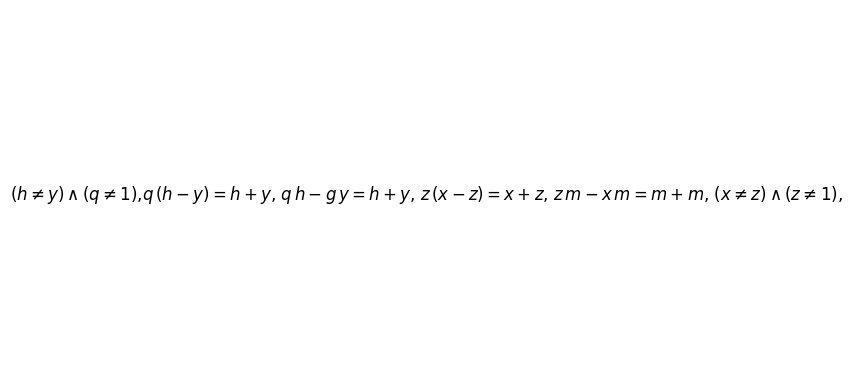

In [55]:
import matplotlib.pyplot as plt

# Example LaTeX expression
a = 8
latex_code = f"${df.iloc[a,1]}$,${df.iloc[a,2]}$, ${df.iloc[a,3]}$, ${df.iloc[a,4]}$, ${df.iloc[a,5]}$, ${df.iloc[a,6]}$,"

# Create a plot to render the LaTeX
plt.text(0.5, 0.5, latex_code, fontsize=12, ha='center', va='center')
plt.axis('off')
plt.show()

In [7]:
import re

def map_variables(expression):
    # Find unique single-letter variables in the order they appear
    variables = []
    for match in re.findall(r'\b[a-zA-Z]\b', expression):
        if match not in variables:
            variables.append(match)

    # Define the target mappings for lowercase and uppercase letters
    targets = "xyz"
    index = 0
    
    # Initialize mappings
    mapping = {}
    
    # Create mappings based on the order of appearance and case
    while index < len(targets) and variables:
        var = variables.pop(0)
        
        # Map the lowercase variable to the lowercase target
        if var.islower():
            mapping[var] = targets[index]
            # Check if the uppercase version also exists and map it to uppercase target
            if var.upper() in variables:
                mapping[var.upper()] = targets[index].upper()
                variables.remove(var.upper())
        
        # Map the uppercase variable to the uppercase target
        elif var.isupper():
            mapping[var] = targets[index].upper()
            # Check if the lowercase version also exists and map it to lowercase target
            if var.lower() in variables:
                mapping[var.lower()] = targets[index]
                variables.remove(var.lower())
        
        index += 1

    # Map the variables in the expression
    mapped_expression = ''.join(mapping.get(char, char) for char in expression)

    return mapped_expression


In [8]:
# Read CSV file into a DataFrame
df = data1

# Assuming the CSV has two columns: 'expr1' and 'expr2'
# You might need to adjust the column names based on your CSV file
for index, row in df.iterrows():
    assumption = row['assumptions']
    expr1 = row['t0']
    expr2 = row['t1']
    
    # Apply variable mapping
    processed_assumption = map_variables(assumption)
    processed_expr1 = map_variables(expr1)
    processed_expr2 = map_variables(expr2)
    


# Optionally save the processed expressions to a new CSV
df['processed_assumption'] = df['assumptions'].apply(map_variables)
df['processed_t0'] = df['t0'].apply(map_variables)
df['processed_t1'] = df['t1'].apply(map_variables)
df.to_csv('processed_expressions.csv', index=False)

In [9]:
import pandas as pd
#from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

# Load a pre-trained embedding model
#model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer('all-MiniLM-L6-v2')

def embed_latex(expressions):
    """
    Generate embeddings for a list of LaTeX expressions.
    
    Args:
    expressions (list): List of LaTeX expression strings.
    
    Returns:
    numpy.ndarray: Array of embeddings for each expression.
    """
    return model.encode(expressions)

# Comparison functions
def compare_clusters(labels1, labels2):
    ari = adjusted_rand_score(labels1, labels2)
    nmi = normalized_mutual_info_score(labels1, labels2)
    fmi = fowlkes_mallows_score(labels1, labels2)
    return ari, nmi, fmi


def cluster_expressions_from_csv(file_path, eps=0.5, min_samples=2):
    """
    Cluster pairs of (Original, Transformation) LaTeX expressions from a CSV file.
    
    Args:
    file_path (str): Path to the CSV file containing the expressions.
    eps (float): DBSCAN epsilon parameter for cluster reach.
    min_samples (int): Minimum number of samples in a neighborhood to form a cluster.
    
    Returns:
    DataFrame: Original CSV with an additional 'Cluster' column indicating cluster label.
    """
    # Read the CSV file into a DataFrame
    data = pd.read_csv(file_path)
    
    # Check that the required columns exist
    if 'processed_t0' not in data.columns or 'processed_t1' not in data.columns:
        raise ValueError("CSV file must contain 'Original' and 'Transformation' columns.")
    
    # Create pairs of "Original: <expression> Transformation: <expression>"
    pairs = [f"Original: {orig} Transformation: {trans}" for orig, trans in zip(data['processed_t0'], data['processed_t1'])]
    
    # Generate embeddings for each expression pair
    embeddings = embed_latex(pairs)
    
    # Perform DBSCAN clustering on embeddings
    clustering_model = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    # Apply clustering algorithms
    kmeans = KMeans(n_clusters=8, random_state=0).fit(embeddings)
    dbscan = DBSCAN(eps=0.5, min_samples=5).fit(embeddings)
    agglo = AgglomerativeClustering(n_clusters=8).fit(embeddings)
    #cluster_labels = clustering_model.fit_predict(embeddings)
    # Get cluster labels from each method
    labels_kmeans = kmeans.labels_
    labels_dbscan = dbscan.labels_
    labels_agglo = agglo.labels_
    
    # Add cluster labels to the original data
    data['labels_dbscan'] = labels_dbscan
    data['labels_kmeans'] = labels_kmeans
    data['labels_agglo'] = labels_agglo

    # Compare clusters from KMeans vs. DBSCAN
    ari_km_db, nmi_km_db, fmi_km_db = compare_clusters(labels_kmeans, labels_dbscan)
    print("KMeans vs DBSCAN")
    print(f"Adjusted Rand Index: {ari_km_db:.3f}")
    print(f"Normalized Mutual Information: {nmi_km_db:.3f}")
    print(f"Fowlkes-Mallows Index: {fmi_km_db:.3f}\n")

    # Compare clusters from KMeans vs. Agglomerative Clustering
    ari_km_ag, nmi_km_ag, fmi_km_ag = compare_clusters(labels_kmeans, labels_agglo)
    print("KMeans vs Agglomerative Clustering")
    print(f"Adjusted Rand Index: {ari_km_ag:.3f}")
    print(f"Normalized Mutual Information: {nmi_km_ag:.3f}")
    print(f"Fowlkes-Mallows Index: {fmi_km_ag:.3f}\n")

    # Compare clusters from DBSCAN vs. Agglomerative Clustering
    ari_db_ag, nmi_db_ag, fmi_db_ag = compare_clusters(labels_dbscan, labels_agglo)
    print("DBSCAN vs Agglomerative Clustering")
    print(f"Adjusted Rand Index: {ari_db_ag:.3f}")
    print(f"Normalized Mutual Information: {nmi_db_ag:.3f}")
    print(f"Fowlkes-Mallows Index: {fmi_db_ag:.3f}\n")
    
    return data

# Example usage
file_path = 'processed_expressions.csv'  # Path to your CSV file
clustered_data = cluster_expressions_from_csv(file_path)

# Display the clustered data


c:\Users\imran.chamieh\Desktop\MethError\MLenv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\imran.chamieh\Desktop\MethError\MLenv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\imran.chamieh\Desktop\MethError\MLenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\imran.chamieh\AppData\Local\Programs\Python\Python311\

KMeans vs DBSCAN
Adjusted Rand Index: 0.201
Normalized Mutual Information: 0.406
Fowlkes-Mallows Index: 0.359

KMeans vs Agglomerative Clustering
Adjusted Rand Index: 0.451
Normalized Mutual Information: 0.576
Fowlkes-Mallows Index: 0.531

DBSCAN vs Agglomerative Clustering
Adjusted Rand Index: 0.164
Normalized Mutual Information: 0.394
Fowlkes-Mallows Index: 0.336



In [15]:
embed_latex("MAx muster").shape

(384,)

In [ ]:
clustered_data['labels_dbscan']

0      -1
1      -1
2      -1
3      -1
4      -1
       ..
2436   -1
2437    3
2438    3
2439   -1
2440    3
Name: labels_dbscan, Length: 2441, dtype: int64

: 

In [23]:
clustered_data = clustered_data[["category","labels_dbscan", "labels_kmeans", "labels_agglo", "processed_t0", "processed_t1", "t0", "t1", "assumptions" ]]

In [ ]:
clustered_data.to_csv("clustred.csv")


: 

In [2]:
pip install --upgrade torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 10.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 12.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━

In [ ]:
l1= ["0 = r - 8*s + 2 " ,"r - 8.0*s = -2.0 " ,"r - 8.0*s + 2.0 = 0 " ,"-r = -4*s - 4*s + 2 " ,"0 = -r + 4*s + 4*s - 2 " ,"-2 = r - 8*s " ,"4*s + 4*s - 2 = r " ,"2 = -r + 8*s " ,"-r - 2 = -4*s - 4*s " ,"-4*s - 4*s + 2 = -r " ,"-8*s = -r - 2 " ,"r = 8*s - 2 " ,"0 = -r + 8.0*s - 2.0 " ,"s = r/8 + 1/4 " ,"2.0 = -r + 8.0*s " ,"2 = -r + 4*s + 4*s " ,"-r + 4*s + 4*s - 2 = 0 " ,"r - 8*s + 2 = 0 " ,"r - 4*s - 4*s = -2 " ,"0 = -r + 4*s + 4*s - 2 " ,"-r + 8.0*s - 2.0 = 0 " ,"r + 2 = 8*s " ,"-r = 2.0 - 8.0*s " ,"0.13*r + 0.25 = s " ,"8.0*s = r + 2.0 " ,"-r + 8*s - 2 = 0 " ,"8*s - 2 = r " ,"-r + 8.0*s = 2.0 " ,"0 = -r + 8*s - 2 " ,"-r + 4*s + 4*s = 2 " ,"-2 = r - 4*s - 4*s " ,"r - 4*s - 4*s + 2 = 0 " ,"0 = r - 4*s - 4*s + 2 " ,"r/8 + 1/4 = s " ,"r = 4*s + 4*s - 2 " ,"-8.0*s = -r - 2.0 " ,"r = 8.0*s - 2.0 " ,"r - 8*s = -2 " ,"-r - 2.0 = -8.0*s " ,"4*s + 4*s - 2 = r " ,"-r + 8*s = 2 " ,"-2 = r - 4*s - 4*s " ,"r + 2 = 4*s + 4*s " ,"2 - 8*s = -r " ,"0 = r - 8.0*s + 2.0 " ,"2.0 - 8.0*s = -r " ,"r = 4*s + 4*s - 2 " ,"-4*s - 4*s + 2 = -r " ,"8.0*s - 2.0 = r " ,"-4*s - 4*s = -r - 2 " ,"2 = -r + 4*s + 4*s " ,"s = 0.13*r + 0.25 " ,"r - 4*s - 4*s + 2 = 0 " ,"-r + 4*s + 4*s - 2 = 0 " ,"r + 2.0 = 8.0*s " ,"4*s + 4*s = r + 2 " ,"8*s = r + 2 " ,"0 = r - 4*s - 4*s + 2 " ,"r - 4*s - 4*s = -2 " ,"-2.0 = r - 8.0*s " ,"-r = 2 - 8*s " ,"-r = -4*s - 4*s + 2 " ,"-r - 2 = -8*s " ,"-r + 4*s + 4*s = 2"]


l2 = [
    "0 = r - 8.0*s + 2.0" ,"r - 8.0*s = -2.0 " ,"r - 8.0*s + 2.0 = 0 " ,"s = 0.13*r + 0.25 " ,"r - 4*s - 4*s + 2 = 0 " ,"r - 8*s + 2 = 0 " ,"-r + 8.0*s - 2.0 = 0 " ,"0 = r - 4*s - 4*s + 2 " ,"-r = -4*s - 4*s + 2 " ,"r + 2 = 8*s " ,"-r = 2 - 8*s " ,"0 = r - 8*s + 2 " ,"s = r/8 + 1/4 " ,"-r = 2.0 - 8.0*s " ,"-r - 2 = -8*s " ,"r - 8*s = -2 " ,"-4*s - 4*s + 2 = -r " ,"r - 4*s - 4*s = -2 " ,"-4*s - 4*s + 2 = -r " ,"0 = r - 4*s - 4*s + 2 " ,"2 = -r + 4*s + 4*s " ,"r + 2.0 = 8.0*s " ,"-r - 2 = -4*s - 4*s " ,"-r + 4*s + 4*s = 2 " ,"0 = -r + 8*s - 2 " ,"8.0*s - 2.0 = r " ,"-8*s = -r - 2 " ,"r = 8.0*s - 2.0 " ,"r - 4*s - 4*s + 2 = 0 " ,"-2.0 = r - 8.0*s " ,"2.0 - 8.0*s = -r " ,"0 = -r + 8.0*s - 2.0 " ,"-r + 4*s + 4*s = 2 " ,"r - 4*s - 4*s = -2 " ,"0 = -r + 4*s + 4*s - 2 " ,"4*s + 4*s - 2 = r " ,"4*s + 4*s = r + 2 " ,"-8.0*s = -r - 2.0 " ,"8.0*s = r + 2.0 " ,"2.0 = -r + 8.0*s " ,"0 = -r + 4*s + 4*s - 2 " ,"r + 2 = 4*s + 4*s " ,"2 - 8*s = -r " ,"2 = -r + 4*s + 4*s " ,"-r + 8.0*s = 2.0 " ,"-2 = r - 4*s - 4*s " ,"-2 = r - 8*s " ,"r = 8*s - 2 " ,"-4*s - 4*s = -r - 2 " ,"-r + 8*s = 2 " ,"8*s - 2 = r " ,"r = 4*s + 4*s - 2 " ,"-r = -4*s - 4*s + 2 " ,"-r + 8*s - 2 = 0 " ,"-2 = r - 4*s - 4*s " ,"4*s + 4*s - 2 = r " ,"r = 4*s + 4*s - 2 " ,"-r + 4*s + 4*s - 2 = 0 " ,"-r + 4*s + 4*s - 2 = 0 " ,"2 = -r + 8*s " ,"-r - 2.0 = -8.0*s " ,"8*s = r + 2"
]

for eq in l1:
    if eq not in l2:
        print(eq)


print("--------")

for eq in l2:
    if eq not in l1:
        print(eq)

0.13*r + 0.25 = s 
r/8 + 1/4 = s 
0 = r - 8.0*s + 2.0 
8*s = r + 2 
-r + 4*s + 4*s = 2
--------
0 = r - 8.0*s + 2.0
8*s = r + 2


: 

In [16]:
import sympy as sp
from difflib import SequenceMatcher
import numpy as np
import logging
from functools import lru_cache
from sympy import Eq, simplify

class SimilarityStrategy:
    """Abstract base class for similarity strategies"""
    def calculate(self, eq1: sp.Eq, eq2: sp.Eq) -> float:
        pass

class StructuralSimilarity(SimilarityStrategy):
    """Structural similarity using sequence matching"""
    @lru_cache(maxsize=1024)
    def _structural_ratio(self, a: str, b: str) -> float:
        return SequenceMatcher(None, a, b).ratio()

    def calculate(self, eq1: Eq, eq2: Eq) -> float:
        try:
            canon1 = simplify(eq1.lhs - eq1.rhs)
            canon2 = simplify(eq2.lhs - eq2.rhs)
            canon3 = simplify(-eq2.lhs + eq2.rhs)
             # Handle cases where simplify() returns True or False
            if isinstance(canon1, bool):
                canon1 = sp.S.Zero
            if isinstance(canon2, bool):
                canon2 = sp.S.Zero
            if isinstance(canon3, bool):
                canon3 = sp.S.Zero

            base_score1 = np.mean([
                self._structural_ratio(sp.srepr(eq1.lhs), sp.srepr(eq2.lhs)),
                self._structural_ratio(sp.srepr(eq1.rhs), sp.srepr(eq2.rhs)),
                self._structural_ratio(sp.srepr(canon1), sp.srepr(canon2))
            ])

            base_score11 = np.mean([
                self._structural_ratio(sp.srepr(eq1.lhs), sp.srepr(eq2.lhs)),
                self._structural_ratio(sp.srepr(eq1.rhs), sp.srepr(eq2.rhs)),
                self._structural_ratio(sp.srepr(canon1), sp.srepr(canon3))
            ])

            base_score2 = np.mean([
                self._structural_ratio(sp.srepr(eq1.rhs), sp.srepr(eq2.lhs)),
                self._structural_ratio(sp.srepr(eq1.lhs), sp.srepr(eq2.rhs)),
                self._structural_ratio(sp.srepr(canon1), sp.srepr(canon2))
            ])

            base_score22 = np.mean([
                self._structural_ratio(sp.srepr(eq1.rhs), sp.srepr(eq2.lhs)),
                self._structural_ratio(sp.srepr(eq1.lhs), sp.srepr(eq2.rhs)),
                self._structural_ratio(sp.srepr(canon1), sp.srepr(canon3))
            ])
            
        
            print(eq1, eq2, max(base_score1, base_score2, base_score11, base_score22))
            return max(base_score1, base_score2, base_score11, base_score22)
        except Exception as e:
            logging.error(f"Structural similarity failed: {str(e)}")
            return 0

# Test cases
similarity_checker = StructuralSimilarity()

x, q, m,a , k, r = sp.symbols('x q m a k r')

eq1 = sp.Eq(x, sp.parse_expr("-1*(a-2)",evaluate=False), evaluate=False)
eq2 = sp.Eq(k, sp.parse_expr("r/4 + 1/2", evaluate=False), evaluate=False)
eq3 = sp.Eq(x, sp.parse_expr("-1*(a-2)",evaluate=False), evaluate=False) # 3*(a*x) + x=-2
eq4 = sp.Eq(x,sp.parse_expr("-3/4"))

eqs = {Eq(m, 0.66*q - 1.33), Eq(-3*m - 2*q + 2*q, 4 - 2*q), Eq(2*q - 1*4, 3*m), Eq(-3*m, 4 - 2*q), Eq(q, 3*m/2 + 2), Eq(-3*m - 4, -3*m + 3*m - 2*q), Eq(-3*m + 2*q, 4), Eq(-4, 3*m - 2*q), Eq(-3*m + 0, -3*m + 3*m - 2*q + 4), Eq(m, 2*q/3 - 4/3), Eq(m, 0.67*q - 1.33), Eq(-3*m - 4, -2*q - 4 + 4), Eq(-4 + 0, 3*m - 2*q - 4 + 4), Eq(-3*m - 4, -2*q), Eq(q, (3*m + 4)/2), Eq(-3*m - 4, -2*q), Eq(-3*m - 2*q + 2*q, 4 - 2*q), Eq(-2*q + 2*q - 4, 3*m - 2*q), Eq(2*q - 1*4, 3*m - 1*4 + 4), Eq(-3*m + 0, -3*m + 3*m - 2*q + 4), Eq(-3*m - 1*4, -2*q), Eq(2*q, 3*m + 4), Eq(-3*m + 2*q, -3*m + 3*m + 4), Eq(-1*4 + 0, 3*m - 2*q), Eq(-3*m, 4 - 2*q), Eq(-1*4 + 0, 3*m - 2*q - 1*4 + 4), Eq(0, 3*m - 2*q + 4), Eq(-4, 3*m - 2*q), Eq(2*q - 4, 3*m), Eq(-2*q + 2*q - 1*4, 3*m - 2*q), Eq(-2*q + 2*q, 3*m - 2*q + 4), Eq(-3*m + 2*q, -3*m + 3*m + 4), Eq(m, (4 - 2*q)/(-3)), Eq(q, 3*m/2 + 2), Eq(-3*m - 1*4, -2*q - 1*4 + 4), Eq(-3*m + 0, 4 - 2*q), Eq(-3*m - 4, -3*m + 3*m - 2*q), Eq(-3*m + 2*q, 4), Eq(0, 3*m - 2*q + 4), Eq(2*q, 3*m + 4), Eq(2*q - 4, 3*m - 4 + 4), Eq(m, (2*q)/3 - 4/3), Eq(-2*q + 2*q, 3*m - 2*q + 4)}
eqs2 = (Eq(r, 4*k - 2), Eq(-4*k - (-1)*2, -r), Eq(0, -(-1)*4*k - r - 2), Eq(-4*k - (-1)*4*k - (-1)*2, -(-1)*4*k - r - 1*2 - (-1)*2), Eq(-4*k - (-1)*4*k, -(-1)*4*k - r - 1*2), Eq(-4*k - (-1)*4*k - (-1)*r - 1*(-2), 4*k), Eq(-r - 2, -4*k), Eq(r + 2, 4*k), Eq(-4*k - (-1)*4*k - (-1)*r - (-1)*2, 4*k), Eq(-2, -4*k + r), Eq(-4*k - (-1)*4*k - (-2), -(-1)*4*k - r - 2 - (-2)), Eq(0 + 1*2, 4*k - r - 2 + 2), Eq(k, (-r - 2)/(-4)), Eq(2, 4*k - r - 2 + 2), Eq(0, -4*k + r + 2), Eq(-4*k - (-1)*4*k - (-1)*r, -(-1)*4*k - r - (-1)*r - 2), Eq(-2, -4*k + r), Eq(-4*k, -r - 2), Eq(-4*k - (-1)*r, -r - (-1)*r - 2), Eq(2, 4*k - r - 1*1*2 + 2), Eq(0, -(-1)*4*k - r - 1*2), Eq(r, (2 - 4*k)/(-1)), Eq(4*k - r - 2, 0), Eq(-4*k + r, -2), Eq(-4*k + r + 2, -2 + 2), Eq(4*k, r + 2), Eq(4*k - 2, r), Eq(-4*k - (-1)*2, -r - 2 - (-1)*2), Eq(-4*k - (-1)*4*k - (-1)*r - (-1)*2, 4*k), Eq(-r - 2, -4*k), Eq(-4*k + r + 1*2, -2 + 2), Eq(-4*k - (-1)*4*k - (-1)*r, 4*k - 2), Eq(-4*k - (-1)*4*k - (-1)*r - (-1)*2, 1*4*k - r - (-1)*r - 2 - (-1)*2), Eq(0, -4*k + r + 2), Eq(-4*k - (-1)*4*k - 1*(-2), 1*4*k - r - 2 - 1*(-2)), Eq(-4*k, -r - 2), Eq(-4*k - (-1)*r, -r - (-1)*r - 1*2), Eq(r, -(-1)*4*k - r - (-1)*r - 2), Eq(-4*k + 1*2, -r - 1*2 + 2), Eq(-4*k + 4*k + r, 4*k - r + r - 2), Eq(k, (-r - 1*2)/(-4)), Eq(4*k - r - 2, 0), Eq(-4*k + r, -2), Eq(0, 4*k - r - 2), Eq(2 - 4*k, -r), Eq(-4*k - (-1)*4*k - (-1)*r - (-1)*2, 1*4*k - r - (-1)*r - 2 - (-1)*2), Eq(-4*k - (-1)*4*k - (-1)*r - 1*(-2), 4*k), Eq(0, -4*k + r + 2), Eq(-4*k - (-1)*4*k - (-1)*r, 1*4*k - r - (-1)*r - 1*2), Eq(-4*k - (-1)*4*k - (-1)*r, -(-1)*4*k - r - (-1)*r - 1*2), Eq(r, 4*k - 1*1*2), Eq(0, 4*k - r - 1*2), Eq(-4*k - (-1)*4*k - (-1)*r - 1*(-2), 1*4*k - r - (-1)*r - 1*2 - 1*(-2)), Eq(0, 4*k - r - 2), Eq(-4*k + 4*k + r + 2, 4*k - r + r - 2 + 2), Eq(4*k - r, 2), Eq(-4*k + r + 2, 0), Eq(-4*k + 4*k, 4*k - r - 2), Eq(k, (r + 2)/4), Eq(-r, 2 - 4*k), Eq(-4*k - (-1)*4*k - (-1)*r - (-2), 1*4*k - r - (-1)*r - 1*2 - (-2)), Eq(r, -(-1)*4*k - r - (-1)*r - 1*2), Eq(2, 4*k - r - 2 + 2), Eq(2, 4*k - r), Eq(-4*k - (-1)*4*k - 1*(-2), 4*k - r), Eq(4*k - 1*1*2, r), Eq(-4*k + r + 2, 0), Eq(-4*k - (-1)*r, -2), Eq(-4*k + r + 1*2, 0), Eq(-4*k + 4*k + 2, 4*k - r - 2 + 2), Eq(-4*k + 4*k + r + 2, 4*k - r + r - 2 + 2), Eq(r + 2, 4*k), Eq(-4*k + r + 2, 0), Eq(-4*k - (-1)*4*k - (-1)*r - 1*(-2), 1*4*k - r - (-1)*r - 1*2 - 1*(-2)), Eq(2, -(-1)*4*k - r - 1*2 - (-1)*2), Eq(r/4 + 1/2, k), Eq(-4*k - (-1)*4*k - (-1)*r - (-2), 4*k), Eq(2, -(-1)*4*k - r - 2 - (-2)), Eq(k, r/4 + 1/2), Eq(r, 4*k - 2), Eq(-4*k - 1*(-2), -r - 1*2 - 1*(-2)), Eq(-4*k + 4*k + r, 4*k - r + r - 2), Eq(-4*k - 1*(-2), -r), Eq(4*k - r, 2), Eq(-r, 2 - 4*k), Eq(2 - 4*k, -r - 2 + 2), Eq(0, 4*k - r - 2), Eq(2 - 4*k, -r - 2 + 2), Eq(4*k - 2, r), Eq(-4*k, -r - 1*2), Eq(2, 4*k - r), Eq(-4*k + r, -r + r - 2), Eq(r + 0, 4*k - 1*2), Eq(-4*k + 4*k + 2, 4*k - r - 2 + 2), Eq(r + 0, 4*k - 2), Eq(0, 4*k - r - 2), Eq(-4*k - (-1)*4*k, -(-1)*4*k - r - 2), Eq(2 - 4*k, -r), Eq(4*k - r - 2, 0), Eq(4*k, r + 2), Eq(k, r/4 + 1/2))
eqs4 = [Eq(8*x, -7 + 1), Eq(8*x - 1*7 + 7, 1 - 1*7), Eq(8*x - 1*7 - 1 + 7, -1*7 - 1 + 1), Eq(-8*x + 8*x - 7 - 1 + 7, -8*x - 7 - 1 + 1), Eq(8*x + 7, 1), Eq(7, 1 - 8*x), Eq(8*x, 1 - 1*7), Eq(x, -3/4), Eq(-8*x + 8*x + 7, 1 - 8*x), Eq(x, -6/8), Eq(-8*x + 8*x - 7 + 7, -8*x - 6), Eq(8*x + 7, 1), Eq(8*x/8, (1 - 7)/8), Eq(-8*x + 8*x - 7 - 1*1 + 7, -8*x - 7), Eq(-8*x + 8*x - 1*7 - 1*1 + 7, -8*x - 1*7 - 1*1 + 1), Eq(-8*x + 8*x + 7, 1 - 8*x), Eq(-8*x + 8*x - 7 - 1 + 7, -8*x - 7 - 1 + 1), Eq(x, -7/8 + 1/8), Eq(-8*x + 8*x - 1 + 7, -8*x - 1 + 1), Eq(-1, -8*x - 1*7 - 1*1 + 1), Eq(6, -8*x - 1 + 1), Eq(8*x + 6, 0), Eq(-8*x + 8*x + 7, 1 - 8*x), Eq(-8*x + 8*x - 1 + 7, -8*x - 1 + 1), Eq(-8*x + 8*x - 7 + 7, -8*x - 6), Eq(-8*x + 8*x - 7 - 1*1 + 7, -8*x - 1*7 - 1*1 + 1), Eq(-1, -8*x - 1*7 - 1*1 + 1), Eq(-8*x + 8*x - 7 - 1*1 + 7, -8*x - 7 - 1*1 + 1), Eq(-1, -8*x - 1*7 - 1*1 + 1), Eq(8*x - 1 + 7, -1 + 1), Eq(8*x/8, -3/4), Eq(0, -8*x - 6), Eq(8*x + 6, -1 + 1), Eq(6, -8*x - 1 + 1), Eq(8*x/8, -6/8), Eq(8*x - 1, -1*7 - 1 + 1), Eq(7, 1 - 8*x), Eq(-8*x + 8*x - 7 + 7, -8*x - 7 + 1), Eq(x, -0.76), Eq(x, -0.75), Eq(8*x - 1*7 - 1 + 7, -7), Eq(8*x - 7 + 7, -6), Eq(8*x - 7 - 1 + 7, -7 - 1 + 1), Eq(8*x - 1*7 + 7, -6), Eq(8*x - 1*1 + 7, 1 - 1*1), Eq(-8*x + 8*x - 1*7 - 1*1 + 7, -8*x - 7), Eq(-1, -8*x - 7 - 1*1 + 1), Eq(-8*x + 8*x - 7 + 7, -8*x - 7 + 1), Eq(8*x, -6), Eq(-8*x + 8*x - 7 - 1*1 + 7, -8*x - 7), Eq(-8*x + 8*x - 7 - 1 + 7, -8*x - 7), Eq(-1, -8*x - 7), Eq(-8*x + 8*x - 1*7 - 1*1 + 7, -8*x - 1*7 - 1*1 + 1), Eq(0, -8*x - 7 + 1), Eq(8*x - 1, -7 - 1 + 1), Eq(-1, -8*x - 7 - 1 + 1), Eq(0, -8*x - 1*7 + 1), Eq(-8*x + 8*x - 1 + 7, -8*x), Eq(8*x - 7 - 1 + 7, -7), Eq(-8*x + 8*x - 1*7 + 7, -8*x - 6), Eq(-8*x + 8*x - 1 + 7, -8*x), Eq(-8*x + 8*x - 7 - 1 + 7, -8*x - 7), Eq(8*x/8, -7/8 + 1/8), Eq(x, (1 - 7)/8), Eq(6, -8*x), Eq(-1, -8*x - 7 - 1 + 1), Eq(8*x + 6, 1 - 1*1), Eq(-8*x + 8*x - 1*7 + 7, -8*x - 1*7 + 1), Eq(0, -8*x - 7 + 1), Eq(8*x - 7 + 7, -7 + 1), Eq(8*x - 1, -7), Eq(-8*x + 8*x - 7 + 7, -8*x - 7 + 1), Eq(0, -8*x - 7 + 1), Eq(-8*x + 8*x - 1*7 - 1*1 + 7, -8*x - 7), Eq(-1, -8*x - 7 - 1 + 1), Eq(-8*x + 8*x - 7 + 7, -8*x - 6), Eq(-8*x + 8*x - 7 - 1 + 7, -8*x - 7), Eq(8*x - 1 + 7, 0), Eq(8*x - 1*1 + 7, 0), Eq(-8*x + 8*x - 7 - 1 + 7, -8*x - 7 - 1 + 1)]
#score1 = similarity_checker.calculate(eq1, eq2)
#score2 = similarity_checker.calculate(eq1, eq3)
i = 1
max_score = 0
best_match = eq4
for eq in eqs4:
    score = similarity_checker.calculate(eq, eq4)
    if score > max_score:
        max_score = score
        best_match = eq

    #print(f"{i} Similarity between '{eq}' and '{eq4}': {score:.4f}")
    i += 1

print(f"Best match for '{eq4}': {best_match} with score: {max_score:.4f}")
#print(eqs2)

score1 = similarity_checker.calculate(eq4, Eq(x, -6/8))
score2 = similarity_checker.calculate(eq4, Eq(x, -3/2))
print(f"score1: {score1:.4f}")
print(f"score2: {score2:.4f}")
#print(f"Similarity between '{eq1}' and '{eq2}': {score1:.4f}")
#print(f"Similarity between '{eq1}' and '{eq3}': {score2:.4f}")


Eq(8*x, -6) Eq(x, -3/4) 0.5475427350427351
Eq(8*x, -6) Eq(x, -3/4) 0.5475427350427351
Eq(8*x - 1, -7) Eq(x, -3/4) 0.4881635177687809
Eq(-1, -8*x - 7) Eq(x, -3/4) 0.46427045177045184
Eq(8*x + 7, 1) Eq(x, -3/4) 0.46789682539682537
Eq(7, 1 - 8*x) Eq(x, -3/4) 0.44322463768115944
Eq(8*x, -6) Eq(x, -3/4) 0.5475427350427351
Eq(x, -0.75) Eq(x, -3/4) 0.6583106815664955
Eq(7, 1 - 8*x) Eq(x, -3/4) 0.44322463768115944
Eq(x, -0.75) Eq(x, -3/4) 0.6583106815664955
Eq(0, -8*x - 6) Eq(x, -3/4) 0.44170634920634927
Eq(8*x + 7, 1) Eq(x, -3/4) 0.46789682539682537
Eq(x, -0.75) Eq(x, -3/4) 0.6583106815664955
Eq(-1, -8*x - 7) Eq(x, -3/4) 0.46427045177045184
Eq(-1, -8*x - 7) Eq(x, -3/4) 0.46427045177045184
Eq(7, 1 - 8*x) Eq(x, -3/4) 0.44322463768115944
Eq(-1, -8*x - 7) Eq(x, -3/4) 0.46427045177045184
Eq(x, -0.75) Eq(x, -3/4) 0.6583106815664955
Eq(6, -8*x) Eq(x, -3/4) 0.4779700854700855
Eq(-1, -8*x - 7) Eq(x, -3/4) 0.46427045177045184
Eq(6, -8*x) Eq(x, -3/4) 0.4779700854700855
Eq(8*x + 6, 0) Eq(x, -3/4) 0.46789

In [ ]:
{Eq(-10*a - 1*(-4), -4 - 1*(-4)), Eq(-10*a - (-1)*10*a + 4, -(-1)*10*a + 0), Eq(4 - 10*a, -4 + 4), Eq(-10*a, -4), Eq(4 - 10*a, 0), Eq(-10*a - 1*(-4), 0), Eq(4, 10*a), Eq(a, 2/5), Eq(-10*a - (-1)*10*a, -(-1)*10*a - 4), Eq(a, -4/(-10)), Eq(0, -(-1)*10*a - 4), Eq(-10*a + 10*a + 4, 10*a + 0), Eq(-10*a + 10*a, 10*a - 4), Eq(4, -(-1)*10*a + 0), Eq(0 - 1*(-4), 10*a), Eq(a, 0.4), Eq(0, 10*a - 4), Eq(0 + 4, 10*a - 4 + 4), Eq(0 - 1*(-4), 10*a - 1*4 - 1*(-4))}

In [ ]:
{Eq(0 - 1*(-1), x - 1), Eq(1 - 2*x, -2*x + x - 1*1), Eq(0, x - 2), Eq(x, 2), Eq(1 - 1*1, x - 1*1 - 1*1), Eq(-x + x + 1, -x + 2*x - 1*1), Eq(-2*x - 1*1 + 1, -x - 1*1 - 1*1), Eq(x + 1, 2*x - 1), Eq(-x + x + 1, -x + 2*x - 1), Eq(1 - 2*x, -2*x + x - 1), Eq(0 - 1*(-1), x - 1*2 - 1*(-1)), Eq(-1 + 1, x - 1 - 1), Eq(-2*x - 1*(-1), -x - 1*2 - 1*(-1)), Eq(-2*x - 1*(-1), -x - 1), Eq(2 - 1*1, x - 1*1), Eq(-2*x + x + 1, -2*x + 2*x - 1), Eq(2 - 1*1, x - 1), Eq(-x + x + 1, -x + 2*x - 1), Eq(-2*x, -x - 2), Eq(x, (-x - 1*2)/(-2)), Eq(x, 2*x - 2), Eq(1 - 2*x, -x - 1), Eq(0, x - 1*1 - 1*1), Eq(1 - 2*x, -x - 1), Eq(x + 1 - 1*(-1), 2*x - 1*1 - 1*(-1)), Eq(x + 1 + 1, 2*x - 1 + 1), Eq(0, -x + 2*x - 1*2), Eq(x, -2/(-1)), Eq(-x - x, -x - 2), Eq(1, x - 1), Eq(x - 1*1 + 2, 2*x - 1*1), Eq(0 + 1, x - 2 + 1), Eq(x - 1 + 1, 2*x - 1 - 1), Eq(-2*x, -x - 1*1 - 1*1), Eq(x + 1 - 1*(-1), 2*x), Eq(-x + x + 2, -x + 2*x), Eq(-2*x + x + 1, -2*x + 2*x - 1), Eq(x, 2*x - 1*1 - 1*1), Eq(-2*x - 1 + 1, -x - 1 - 1), Eq(-2*x + 0, -2*x + x - 1*2), Eq(1 - x, -1), Eq(-x, -2), Eq(x, 2*x - 1 - 1*1), Eq(-x, -1 - 1*1), Eq(2, -x + 2*x), Eq(2, x), Eq(x + 2, 2*x), Eq(-2*x + x + 1, -2*x + 2*x - 1*1), Eq(x + 1, 2*x - 1*1), Eq(x, (-x - 1 - 1)/(-2)), Eq(1, -x + 2*x - 1*1), Eq(x, x/2 + 1), Eq(1 - 2*x, -x - 2 + 1), Eq(-2*x + 0, -2*x + x - 2), Eq(x - 1*1 + 2, 2*x - 1), Eq(-x + x, -x + 2*x - 1*2), Eq(x, (-1 - 1)/(-1)), Eq(-x - 1 + 1, -1 - 1), Eq(x - 1*1 + 1, 2*x - 1*1 - 1*1), Eq(-2*x - (-1), -x - 1*2 - (-1)), Eq(1, -x + 2*x - 1), Eq(-1 + 2, x - 1), Eq(x + 1 - (-1), 2*x - 1 - (-1)), Eq(x - 1*1 + 1, 2*x - 1 - 1*1), Eq(-2*x + x + 1, -1), Eq(-2*x - (-1), -x - 1), Eq(-x - 1*1 + 1, -1 - 1*1), Eq(-x + x, -x + 2*x - 2), Eq(x, x/2 + 1/2 + 1/2), Eq(x, 1 + 1), Eq(x + 1 - (-1), 2*x), Eq(-x - x + 1, -x - 1), Eq(-2*x + 0, -x - 2), Eq(x - 1 + 2, 2*x - 1)}

In [7]:
from sympy import symbols, Eq, simplify
import sympy 

x = symbols('x')
equation = Eq(x, sympy.parse_expr("6*x/8-4/6", evaluate=False))

# Simplify the right-hand side
simplified_equation = Eq(equation.lhs, simplify(equation.rhs))

print(equation)  # Output: Eq(x, -2/3)
print(simplified_equation)  # Output: x = -2/3


Eq(x, 6*x/8 - 4/6)
Eq(x, 3*x/4 - 2/3)


In [8]:
from sympy import symbols, Eq, simplify, factor_terms, parse_expr

x = symbols('x')
equation = Eq(x, parse_expr("6*x/8-4/6", evaluate=False))

# Simplify and factor numerical coefficients
rhs_simplified = factor_terms(simplify(equation.rhs))

simplified_equation = Eq(equation.lhs, rhs_simplified)

print(equation)   
print(simplified_equation)


Eq(x, 6*x/8 - 4/6)
Eq(x, (9*x - 8)/12)


In [3]:
from sympy import symbols, Eq, simplify, factor_terms, parse_expr, Add

x = symbols('x')
equation = Eq(x, parse_expr("6*x/8 + 4/-6", evaluate=False))

# Separate terms and apply factor_terms to each term individually
rhs_terms = [factor_terms(term) for term in Add.make_args(simplify(equation.rhs))]

# Reconstruct the right-hand side with properly formatted terms
rhs_simplified = Add(*rhs_terms, evaluate=False)

simplified_equation = Eq(simplify(equation.lhs), simplify(equation.rhs))

print(equation)   
print(simplified_equation)


Eq(x, 6*x/8 + 4/(-6))
Eq(x, 3*x/4 - 2/3)


In [4]:
import sympy as sp

expr = sp.parse_expr("6/8*x - 4/6+ 1/3", evaluate=False)
print(expr)  # Output: (9*x - 8)/12
expr = sp.parse_expr("6/8*x - 4/6", evaluate=False)
simplified_expr = sp.simplify(expr)
print(simplified_expr)  # Output: 3*x/4 - 2/3



6*x/8 - 4/6 + 1/3
3*x/4 - 2/3


In [14]:
test_set = {"1", "2", "1"}
print(test_set)

{'2', '1'}


In [6]:
def is_linear( expr: sp.Expr) -> bool:
        """Check if an expression is linear while also ensuring no fractions or square roots"""
        try:
            poly = expr.as_poly()
            if poly is None or poly.degree() != 1:
                return False
            
            # Check for fractions
            if any(term.is_Pow and term.exp.is_Number and term.exp < 0 for term in expr.atoms(sp.Pow)):
                return False
            
            # check if the equation contrin "sqrt" function
            #if any(term.has(sp.sqrt) for term in expr.atoms(sp.Function)):
             #   return False

            # Check for square roots
            if any(term.is_Pow and term.exp == sp.Rational(1, 2) for term in expr.atoms(sp.Pow)):
                return False

            return True
        except Exception as e:
            return False
        
from sympy import symbols, Eq, simplify, factor_terms, parse_expr, Add

x = symbols('x')
equation = Eq(x, parse_expr("sqrt(25) + 4/-6", evaluate=False))

print(is_linear(equation.rhs))  # Output: False
print(is_linear(equation.lhs))  # Output: True


False
True


In [23]:
import sympy as sp
from difflib import SequenceMatcher
import numpy as np
import logging
from functools import lru_cache
from sympy import Eq, simplify

class SimilarityStrategy:
    """Abstract base class for similarity strategies"""
    def calculate(self, eq1: sp.Eq, eq2: sp.Eq) -> float:
        pass

class StructuralSimilarity(SimilarityStrategy):
    """Structural similarity using sequence matching"""
    @lru_cache(maxsize=1024)
    def _structural_ratio(self, a: str, b: str) -> float:
        return SequenceMatcher(None, a, b).ratio()

    def calculate(self, eq1: Eq, eq2: Eq) -> float:
        try:
            canon1 = simplify(eq1.lhs - eq1.rhs)
            canon2 = simplify(eq2.lhs - eq2.rhs)
            canon3 = simplify(-eq2.lhs + eq2.rhs)
             # Handle cases where simplify() returns True or False
            if isinstance(canon1, bool):
                canon1 = sp.S.Zero
            if isinstance(canon2, bool):
                canon2 = sp.S.Zero
            if isinstance(canon3, bool):
                canon3 = sp.S.Zero

            base_score1 = np.mean([
                self._structural_ratio(sp.srepr(eq1.lhs), sp.srepr(eq2.lhs)),
                self._structural_ratio(sp.srepr(eq1.rhs), sp.srepr(eq2.rhs)),
                self._structural_ratio(sp.srepr(canon1), sp.srepr(canon2))
            ])

            base_score11 = np.mean([
                self._structural_ratio(sp.srepr(eq1.lhs), sp.srepr(eq2.lhs)),
                self._structural_ratio(sp.srepr(eq1.rhs), sp.srepr(eq2.rhs)),
                self._structural_ratio(sp.srepr(canon1), sp.srepr(canon3))
            ])

            base_score2 = np.mean([
                self._structural_ratio(sp.srepr(eq1.rhs), sp.srepr(eq2.lhs)),
                self._structural_ratio(sp.srepr(eq1.lhs), sp.srepr(eq2.rhs)),
                self._structural_ratio(sp.srepr(canon1), sp.srepr(canon2))
            ])

            base_score22 = np.mean([
                self._structural_ratio(sp.srepr(eq1.rhs), sp.srepr(eq2.lhs)),
                self._structural_ratio(sp.srepr(eq1.lhs), sp.srepr(eq2.rhs)),
                self._structural_ratio(sp.srepr(canon1), sp.srepr(canon3))
            ])
            
        
            #print(eq1, eq2, max(base_score1, base_score2, base_score11, base_score22))
            return max(base_score1, base_score2, base_score11, base_score22)
        except Exception as e:
            logging.error(f"Structural similarity failed: {str(e)}")
            return 0

# Test cases
similarity_checker = StructuralSimilarity()

x, q, m,a , k, r = sp.symbols('x q m a k r')

eq1 = sp.Eq(x, sp.parse_expr("-1*(a-2)",evaluate=False), evaluate=False)
eq2 = sp.Eq(k, sp.parse_expr("r/4 + 1/2", evaluate=False), evaluate=False)
eq3 = sp.Eq(x, sp.parse_expr("-1*(a-2)",evaluate=False), evaluate=False) # 3*(a*x) + x=-2
eq4 = sp.Eq(x,sp.parse_expr("-3/4"))

eqs = {Eq(m, 0.66*q - 1.33), Eq(-3*m - 2*q + 2*q, 4 - 2*q), Eq(2*q - 1*4, 3*m), Eq(-3*m, 4 - 2*q), Eq(q, 3*m/2 + 2), Eq(-3*m - 4, -3*m + 3*m - 2*q), Eq(-3*m + 2*q, 4), Eq(-4, 3*m - 2*q), Eq(-3*m + 0, -3*m + 3*m - 2*q + 4), Eq(m, 2*q/3 - 4/3), Eq(m, 0.67*q - 1.33), Eq(-3*m - 4, -2*q - 4 + 4), Eq(-4 + 0, 3*m - 2*q - 4 + 4), Eq(-3*m - 4, -2*q), Eq(q, (3*m + 4)/2), Eq(-3*m - 4, -2*q), Eq(-3*m - 2*q + 2*q, 4 - 2*q), Eq(-2*q + 2*q - 4, 3*m - 2*q), Eq(2*q - 1*4, 3*m - 1*4 + 4), Eq(-3*m + 0, -3*m + 3*m - 2*q + 4), Eq(-3*m - 1*4, -2*q), Eq(2*q, 3*m + 4), Eq(-3*m + 2*q, -3*m + 3*m + 4), Eq(-1*4 + 0, 3*m - 2*q), Eq(-3*m, 4 - 2*q), Eq(-1*4 + 0, 3*m - 2*q - 1*4 + 4), Eq(0, 3*m - 2*q + 4), Eq(-4, 3*m - 2*q), Eq(2*q - 4, 3*m), Eq(-2*q + 2*q - 1*4, 3*m - 2*q), Eq(-2*q + 2*q, 3*m - 2*q + 4), Eq(-3*m + 2*q, -3*m + 3*m + 4), Eq(m, (4 - 2*q)/(-3)), Eq(q, 3*m/2 + 2), Eq(-3*m - 1*4, -2*q - 1*4 + 4), Eq(-3*m + 0, 4 - 2*q), Eq(-3*m - 4, -3*m + 3*m - 2*q), Eq(-3*m + 2*q, 4), Eq(0, 3*m - 2*q + 4), Eq(2*q, 3*m + 4), Eq(2*q - 4, 3*m - 4 + 4), Eq(m, (2*q)/3 - 4/3), Eq(-2*q + 2*q, 3*m - 2*q + 4)}
eqs2 = (Eq(r, 4*k - 2), Eq(-4*k - (-1)*2, -r), Eq(0, -(-1)*4*k - r - 2), Eq(-4*k - (-1)*4*k - (-1)*2, -(-1)*4*k - r - 1*2 - (-1)*2), Eq(-4*k - (-1)*4*k, -(-1)*4*k - r - 1*2), Eq(-4*k - (-1)*4*k - (-1)*r - 1*(-2), 4*k), Eq(-r - 2, -4*k), Eq(r + 2, 4*k), Eq(-4*k - (-1)*4*k - (-1)*r - (-1)*2, 4*k), Eq(-2, -4*k + r), Eq(-4*k - (-1)*4*k - (-2), -(-1)*4*k - r - 2 - (-2)), Eq(0 + 1*2, 4*k - r - 2 + 2), Eq(k, (-r - 2)/(-4)), Eq(2, 4*k - r - 2 + 2), Eq(0, -4*k + r + 2), Eq(-4*k - (-1)*4*k - (-1)*r, -(-1)*4*k - r - (-1)*r - 2), Eq(-2, -4*k + r), Eq(-4*k, -r - 2), Eq(-4*k - (-1)*r, -r - (-1)*r - 2), Eq(2, 4*k - r - 1*1*2 + 2), Eq(0, -(-1)*4*k - r - 1*2), Eq(r, (2 - 4*k)/(-1)), Eq(4*k - r - 2, 0), Eq(-4*k + r, -2), Eq(-4*k + r + 2, -2 + 2), Eq(4*k, r + 2), Eq(4*k - 2, r), Eq(-4*k - (-1)*2, -r - 2 - (-1)*2), Eq(-4*k - (-1)*4*k - (-1)*r - (-1)*2, 4*k), Eq(-r - 2, -4*k), Eq(-4*k + r + 1*2, -2 + 2), Eq(-4*k - (-1)*4*k - (-1)*r, 4*k - 2), Eq(-4*k - (-1)*4*k - (-1)*r - (-1)*2, 1*4*k - r - (-1)*r - 2 - (-1)*2), Eq(0, -4*k + r + 2), Eq(-4*k - (-1)*4*k - 1*(-2), 1*4*k - r - 2 - 1*(-2)), Eq(-4*k, -r - 2), Eq(-4*k - (-1)*r, -r - (-1)*r - 1*2), Eq(r, -(-1)*4*k - r - (-1)*r - 2), Eq(-4*k + 1*2, -r - 1*2 + 2), Eq(-4*k + 4*k + r, 4*k - r + r - 2), Eq(k, (-r - 1*2)/(-4)), Eq(4*k - r - 2, 0), Eq(-4*k + r, -2), Eq(0, 4*k - r - 2), Eq(2 - 4*k, -r), Eq(-4*k - (-1)*4*k - (-1)*r - (-1)*2, 1*4*k - r - (-1)*r - 2 - (-1)*2), Eq(-4*k - (-1)*4*k - (-1)*r - 1*(-2), 4*k), Eq(0, -4*k + r + 2), Eq(-4*k - (-1)*4*k - (-1)*r, 1*4*k - r - (-1)*r - 1*2), Eq(-4*k - (-1)*4*k - (-1)*r, -(-1)*4*k - r - (-1)*r - 1*2), Eq(r, 4*k - 1*1*2), Eq(0, 4*k - r - 1*2), Eq(-4*k - (-1)*4*k - (-1)*r - 1*(-2), 1*4*k - r - (-1)*r - 1*2 - 1*(-2)), Eq(0, 4*k - r - 2), Eq(-4*k + 4*k + r + 2, 4*k - r + r - 2 + 2), Eq(4*k - r, 2), Eq(-4*k + r + 2, 0), Eq(-4*k + 4*k, 4*k - r - 2), Eq(k, (r + 2)/4), Eq(-r, 2 - 4*k), Eq(-4*k - (-1)*4*k - (-1)*r - (-2), 1*4*k - r - (-1)*r - 1*2 - (-2)), Eq(r, -(-1)*4*k - r - (-1)*r - 1*2), Eq(2, 4*k - r - 2 + 2), Eq(2, 4*k - r), Eq(-4*k - (-1)*4*k - 1*(-2), 4*k - r), Eq(4*k - 1*1*2, r), Eq(-4*k + r + 2, 0), Eq(-4*k - (-1)*r, -2), Eq(-4*k + r + 1*2, 0), Eq(-4*k + 4*k + 2, 4*k - r - 2 + 2), Eq(-4*k + 4*k + r + 2, 4*k - r + r - 2 + 2), Eq(r + 2, 4*k), Eq(-4*k + r + 2, 0), Eq(-4*k - (-1)*4*k - (-1)*r - 1*(-2), 1*4*k - r - (-1)*r - 1*2 - 1*(-2)), Eq(2, -(-1)*4*k - r - 1*2 - (-1)*2), Eq(r/4 + 1/2, k), Eq(-4*k - (-1)*4*k - (-1)*r - (-2), 4*k), Eq(2, -(-1)*4*k - r - 2 - (-2)), Eq(k, r/4 + 1/2), Eq(r, 4*k - 2), Eq(-4*k - 1*(-2), -r - 1*2 - 1*(-2)), Eq(-4*k + 4*k + r, 4*k - r + r - 2), Eq(-4*k - 1*(-2), -r), Eq(4*k - r, 2), Eq(-r, 2 - 4*k), Eq(2 - 4*k, -r - 2 + 2), Eq(0, 4*k - r - 2), Eq(2 - 4*k, -r - 2 + 2), Eq(4*k - 2, r), Eq(-4*k, -r - 1*2), Eq(2, 4*k - r), Eq(-4*k + r, -r + r - 2), Eq(r + 0, 4*k - 1*2), Eq(-4*k + 4*k + 2, 4*k - r - 2 + 2), Eq(r + 0, 4*k - 2), Eq(0, 4*k - r - 2), Eq(-4*k - (-1)*4*k, -(-1)*4*k - r - 2), Eq(2 - 4*k, -r), Eq(4*k - r - 2, 0), Eq(4*k, r + 2), Eq(k, r/4 + 1/2))
eqs4 = [Eq(8*x, -7 + 1), Eq(8*x - 1*7 + 7, 1 - 1*7), Eq(8*x - 1*7 - 1 + 7, -1*7 - 1 + 1), Eq(-8*x + 8*x - 7 - 1 + 7, -8*x - 7 - 1 + 1), Eq(8*x + 7, 1), Eq(7, 1 - 8*x), Eq(8*x, 1 - 1*7), Eq(x, -3/4), Eq(-8*x + 8*x + 7, 1 - 8*x), Eq(x, -6/8), Eq(-8*x + 8*x - 7 + 7, -8*x - 6), Eq(8*x + 7, 1), Eq(8*x/8, (1 - 7)/8), Eq(-8*x + 8*x - 7 - 1*1 + 7, -8*x - 7), Eq(-8*x + 8*x - 1*7 - 1*1 + 7, -8*x - 1*7 - 1*1 + 1), Eq(-8*x + 8*x + 7, 1 - 8*x), Eq(-8*x + 8*x - 7 - 1 + 7, -8*x - 7 - 1 + 1), Eq(x, -7/8 + 1/8), Eq(-8*x + 8*x - 1 + 7, -8*x - 1 + 1), Eq(-1, -8*x - 1*7 - 1*1 + 1), Eq(6, -8*x - 1 + 1), Eq(8*x + 6, 0), Eq(-8*x + 8*x + 7, 1 - 8*x), Eq(-8*x + 8*x - 1 + 7, -8*x - 1 + 1), Eq(-8*x + 8*x - 7 + 7, -8*x - 6), Eq(-8*x + 8*x - 7 - 1*1 + 7, -8*x - 1*7 - 1*1 + 1), Eq(-1, -8*x - 1*7 - 1*1 + 1), Eq(-8*x + 8*x - 7 - 1*1 + 7, -8*x - 7 - 1*1 + 1), Eq(-1, -8*x - 1*7 - 1*1 + 1), Eq(8*x - 1 + 7, -1 + 1), Eq(8*x/8, -3/4), Eq(0, -8*x - 6), Eq(8*x + 6, -1 + 1), Eq(6, -8*x - 1 + 1), Eq(8*x/8, -6/8), Eq(8*x - 1, -1*7 - 1 + 1), Eq(7, 1 - 8*x), Eq(-8*x + 8*x - 7 + 7, -8*x - 7 + 1), Eq(x, -0.76), Eq(x, -0.75), Eq(8*x - 1*7 - 1 + 7, -7), Eq(8*x - 7 + 7, -6), Eq(8*x - 7 - 1 + 7, -7 - 1 + 1), Eq(8*x - 1*7 + 7, -6), Eq(8*x - 1*1 + 7, 1 - 1*1), Eq(-8*x + 8*x - 1*7 - 1*1 + 7, -8*x - 7), Eq(-1, -8*x - 7 - 1*1 + 1), Eq(-8*x + 8*x - 7 + 7, -8*x - 7 + 1), Eq(8*x, -6), Eq(-8*x + 8*x - 7 - 1*1 + 7, -8*x - 7), Eq(-8*x + 8*x - 7 - 1 + 7, -8*x - 7), Eq(-1, -8*x - 7), Eq(-8*x + 8*x - 1*7 - 1*1 + 7, -8*x - 1*7 - 1*1 + 1), Eq(0, -8*x - 7 + 1), Eq(8*x - 1, -7 - 1 + 1), Eq(-1, -8*x - 7 - 1 + 1), Eq(0, -8*x - 1*7 + 1), Eq(-8*x + 8*x - 1 + 7, -8*x), Eq(8*x - 7 - 1 + 7, -7), Eq(-8*x + 8*x - 1*7 + 7, -8*x - 6), Eq(-8*x + 8*x - 1 + 7, -8*x), Eq(-8*x + 8*x - 7 - 1 + 7, -8*x - 7), Eq(8*x/8, -7/8 + 1/8), Eq(x, (1 - 7)/8), Eq(6, -8*x), Eq(-1, -8*x - 7 - 1 + 1), Eq(8*x + 6, 1 - 1*1), Eq(-8*x + 8*x - 1*7 + 7, -8*x - 1*7 + 1), Eq(0, -8*x - 7 + 1), Eq(8*x - 7 + 7, -7 + 1), Eq(8*x - 1, -7), Eq(-8*x + 8*x - 7 + 7, -8*x - 7 + 1), Eq(0, -8*x - 7 + 1), Eq(-8*x + 8*x - 1*7 - 1*1 + 7, -8*x - 7), Eq(-1, -8*x - 7 - 1 + 1), Eq(-8*x + 8*x - 7 + 7, -8*x - 6), Eq(-8*x + 8*x - 7 - 1 + 7, -8*x - 7), Eq(8*x - 1 + 7, 0), Eq(8*x - 1*1 + 7, 0), Eq(-8*x + 8*x - 7 - 1 + 7, -8*x - 7 - 1 + 1)]
#score1 = similarity_checker.calculate(eq1, eq2)
#score2 = similarity_checker.calculate(eq1, eq3)
i = 1
max_score = 0
best_match = eq4
for eq in eqs4:
    score = similarity_checker.calculate(eq, eq4)
    if score > max_score:
        max_score = score
        best_match = eq

    #print(f"{i} Similarity between '{eq}' and '{eq4}': {score:.4f}")
    i += 1

print(f"Best match for '{eq4}': {best_match} with score: {max_score:.4f}")
#print(eqs2)

score1 = similarity_checker.calculate(eq4, Eq(sp.parse_expr("x"), sp.parse_expr("-6/8", evaluate=False)))
score2 = similarity_checker.calculate(eq4, Eq(sp.parse_expr("x"),sp.parse_expr("-3/4", evaluate=False)))
print(f"score1: {score1:.4f}")
print(f"score2: {score2:.4f}")
#print(f"Similarity between '{eq1}' and '{eq2}': {score1:.4f}")
#print(f"Similarity between '{eq1}' and '{eq3}': {score2:.4f}")


Best match for 'Eq(x, -3/4)': Eq(x, -0.75) with score: 0.6583
score1: 0.7215
score2: 0.7306


In [ ]:
{Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 + 5 + 6, 1 - 7*x), Eq(0, -7*x + 0 - 1*(-1)), Eq(-7*x + 7*x - 1 + 0 + 1, 1 - 7*x), Eq(-7*x + 7*x - 1 + 0 + 1, -7*x + 0 + 0 + 1), Eq(7*x - 1, 0 - 1*0), Eq(7*x - 1 + 0, 0 + 0), Eq(7*x - 1*1 - 1*0, 0), Eq(2*x + 5*x - 6 + 0 + 5, 0), Eq(2*x + 5*x - 6 - 1*5 + 5, -1*5 + 0), Eq(5*x + 5, -2*x + 0 - (-1)*6), Eq(x, (0 - (-1))/7), Eq(-7*x + 7*x - 1*1, -7*x + 0), Eq(-7*x + 7*x - 1 + 0 + 1, 1 - 7*x), Eq(-6, -5*x - 2*x - 1*5 + 0 - 0), Eq(7*x, 0 + 1), Eq(0, -5*x - 2*x - 5 + 0 - (-1)*6), Eq(0, 1 - 7*x), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 - 1*0 + 5 - (-1)*6, 1 - 7*x), Eq(0, -7*x + 0 + 0 + 1), Eq(7*x, 0 - 0 - 1*(-1)), Eq(5*x - 1, -2*x + 0 + 0), Eq(x, 0.14), Eq(-2*x + 2*x + 5*x - 6 - 5 + 5, -2*x - 5), Eq(-2*x + 2*x + 5*x - 6 + 5, -2*x + 0), Eq(5*x - 6, -2*x - 1*5 + 0), Eq(0, -7*x + 0 + 1), Eq(-5*x - 2*x + 2*x + 5*x - 6 + 5 - (-1)*6, 6 - 7*x), Eq(7*x/7, 0 + 1/7), Eq(0, -5*x - 2*x - 1*5 + 0 - (-1)*6), Eq(0, -5*x - 2*x - 5 + 0 - 1*0 - (-1)*6), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 - 1*0 + 5 - (-1)*6, -5*x - 2*x - 5 + 0 - 1*0 - (-1)*6), Eq(-5*x - 2*x + 2*x + 5*x - 6 + 0 + 5, -5*x - 2*x + 0 + 0), Eq(-7*x + 7*x - 1, -7*x), Eq(-1, -5*x - 2*x + 0 + 0), Eq(-5*x + 2*x + 5*x - 6 + 5, -5*x + 0), Eq(-5*x - 2*x + 2*x + 5*x - 1*6 + 5, -5*x - 2*x + 0), Eq(0, -5*x - 2*x - 5 + 0 + 6), Eq(7*x/7, 1/7), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 1*5 - 1*0 + 5 - (-1)*6, -5*x - 2*x - 5 + 0 - 1*0 - (-1)*6), Eq(-1, -5*x - 2*x + 0), Eq(-5*x - 2*x + 2*x + 5*x - 1*6 - 1*5 - 0 + 5, -5*x - 2*x - 1*5 + 0 - 0), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 1*5 + 5, -7*x - 5), Eq(-2*x + 2*x + 5*x - 6 + 5, -2*x), Eq(-5*x - 2*x + 2*x + 5*x - 1*6 + 5, -7*x), Eq(7*x - 1 + 1, 1), Eq(-5*x - 2*x + 2*x + 5*x - 6 + 0 + 5, -7*x), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 + 0 + 5 + 6, -5*x - 2*x - 5 + 0 + 0 + 6), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 + 0 + 5, -7*x - 5), Eq(-1, -7*x), Eq(-5*x - 2*x + 2*x + 5*x - 1*6 + 5, -7*x), Eq(7*x - 1*1 - 1*(-1), 1), Eq(0, -5*x - 2*x - 1*5 + 0 - (-1)*6), Eq(-1, -5*x - 2*x + 0), Eq(-5*x + 2*x + 5*x - 6 + 5, -5*x), Eq(5*x - 1, -2*x + 0), Eq(2*x - 1, -5*x + 0), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 + 5 + 6, -5*x - 2*x - 5 + 0 + 6), Eq(-2*x + 2*x + 5*x - 6 + 5, -2*x), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 - 1*0 + 5 - (-1)*6, -5*x - 2*x - 5 + 0 - 1*0 - (-1)*6), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 1*5 + 5, -5*x - 2*x - 1*5 + 0), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 + 5, -5*x - 2*x - 5 + 0), Eq(-6, -7*x - 5), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 + 5, -7*x - 5), Eq(-2*x + 2*x + 5*x - 1*6 - 5 + 5, -2*x - 1*5 + 0), Eq(7*x - 1, 0), Eq(-7*x + 7*x - 1*1 - 1*0 - 1*(-1), -7*x + 0 - 1*0 - 1*(-1)), Eq(-2*x + 2*x + 5*x - 1*6 + 5 - (-1)*6, 6 - 2*x), Eq(-1, -5*x - 2*x + 0 - 1*0), Eq(-5*x - 2*x + 2*x + 5*x - 6 + 5, -7*x), Eq(-5*x - 2*x + 2*x + 5*x - 1*6 - 1*5 + 5 - (-1)*6, 1 - 7*x), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 + 0 + 5 + 6, 1 - 7*x), Eq(-5*x - 2*x + 2*x + 5*x - 6 + 5, -5*x - 2*x + 0), Eq(0, -5*x - 2*x - 5 + 0 + 6), Eq(-2*x + 2*x + 5*x - 6 + 0 + 5, -2*x), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 1*5 - 1*0 + 5 - (-1)*6, 1 - 7*x), Eq(-1, -5*x - 2*x + 0), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 + 5 + 6, -5*x - 2*x - 5 + 0 + 6), Eq(2*x + 5*x - 6 + 5 - (-1)*6, 6), Eq(2*x + 5*x - 6 - 5 + 5, -5 + 0), Eq(0, -7*x + 0 - 1*0 - (-1)), Eq(-5*x + 2*x + 5*x - 6 + 5, -5*x + 0), Eq(7*x - 1 + 0 + 1, 0 + 0 + 1), Eq(-2*x + 2*x + 5*x - 1*6 - 5 + 5, -2*x - 5), Eq(7*x/7, 1/7), Eq(7*x - 6, -5), Eq(2*x + 5*x - 6 + 5 - (-1)*6, 0 - (-1)*6), Eq(-1, -7*x + 0), Eq(x, 0 + 1/7), Eq(-7*x + 7*x - 1 + 0 + 1, -7*x + 0 + 0 + 1), Eq(-2*x + 2*x + 5*x - 6 + 5 + 6, -2*x + 0 + 6), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 - 1*0 + 5 - (-1)*6, 1 - 7*x), Eq(-5*x - 2*x + 2*x + 5*x - 1*6 - 1*5 - 0 + 5, -7*x - 5), Eq(0, -5*x - 2*x - 1*5 + 0 - 1*0 - (-1)*6), Eq(5*x - 1, -2*x), Eq(0, -7*x + 0 - 1*0 - 1*(-1)), Eq(0, -7*x + 0 + 0 + 1), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 + 0 + 5 + 6, -5*x - 2*x - 5 + 0 + 0 + 6), Eq(5*x - 1, -2*x + 0 - 0), Eq(-5*x - 2*x + 2*x + 5*x - 1*6 - 1*5 + 5 - (-1)*6, -5*x - 2*x - 1*5 + 0 - (-1)*6), Eq(x, 1/7), Eq(-7*x + 7*x - 1*1 - 1*0 - (-1), 1 - 7*x), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 1*5 + 5, -5*x - 2*x - 5 + 0), Eq(7*x - 1 + 1, 0 + 1), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 + 5 + 6, 1 - 7*x), Eq(-5*x - 2*x + 2*x + 5*x - 6 + 5, -7*x), Eq(7*x, 0 + 0 + 1), Eq(-7*x + 7*x - 1 - (-1), 1 - 7*x), Eq(2*x + 5*x - 6 - 1*5 + 5, -5), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 + 0 + 5, -5*x - 2*x - 5 + 0 + 0), Eq(2*x + 5*x - 6 + 5 + 6, 0 + 6), Eq(5*x + 5, -2*x + 0 + 6), Eq(-1, -5*x - 2*x + 0), Eq(7*x/7, 0 + 0 + 1/7), Eq(-5*x - 2*x + 2*x + 5*x - 1*6 + 5, -5*x - 2*x + 0), Eq(5*x + 5, 6 - 2*x), Eq(-7*x + 7*x - 1, -7*x + 0), Eq(2*x + 5*x - 1*6 + 5, 0), Eq(2*x + 5*x - 6 - 1*0 + 5, 0 - 1*0), Eq(-6, -5*x - 2*x - 5 + 0), Eq(-6, -5*x - 2*x - 5 + 0), Eq(7*x, 0 - 1*(-1)), Eq(-1, -7*x + 0), Eq(7*x + 5, 0 + 6), Eq(2*x + 5*x - 6 + 0 + 5, 0 + 0), Eq(7*x - 1 + 0 + 1, 1), Eq(7*x - 6, -1*5 + 0), Eq(-6, -5*x - 2*x - 5 + 0 + 0), Eq(-2*x + 2*x + 5*x - 6 + 5, -2*x + 0), Eq(2*x + 5*x - 6 - 5 + 5, -5), Eq(7*x - 1, 0 + 0), Eq(-5*x - 2*x + 2*x + 5*x - 6 + 5, -5*x - 2*x + 0), Eq(-7*x + 7*x - 1*1, -7*x), Eq(7*x - 1 + 0, 0), Eq(2*x - 1, -5*x), Eq(7*x/7, (0 - 1*0 - (-1))/7), Eq(0, -5*x - 2*x - 5 + 0 + 0 + 6), Eq(x, 1/7), Eq(-7*x + 7*x - 1*1 - 1*0 - (-1), -7*x + 0 - 1*0 - (-1)), Eq(5, -5*x - 2*x + 0 - (-1)*6), Eq(-7*x + 7*x - 1 + 1, -7*x + 0 + 1), Eq(-7*x + 7*x - 1 - (-1), -7*x + 0 - (-1)), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 1*5 - 1*0 + 5 - (-1)*6, -5*x - 2*x - 1*5 + 0 - 1*0 - (-1)*6), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 1*5 + 5, -7*x - 5), Eq(x, (0 - 1*0 - (-1))/7), Eq(5, -5*x - 2*x + 0 + 6), Eq(-2*x + 2*x + 5*x - 6 + 5 + 6, 6 - 2*x), Eq(7*x/7, (0 - (-1))/7), Eq(7*x - 1*1 - 1*0, 0 - 1*0), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 1*0 + 5, -7*x), Eq(-5*x - 2*x + 2*x + 5*x - 6 + 5 + 6, -5*x - 2*x + 0 + 6), Eq(-2*x + 2*x + 5*x - 1*6 + 5 - (-1)*6, -2*x + 0 - (-1)*6), Eq(-5*x - 2*x + 2*x + 5*x - 1*6 - 5 + 5 - (-1)*6, -5*x - 2*x - 5 + 0 - (-1)*6), Eq(7*x, 1), Eq(-5*x - 2*x + 2*x + 5*x - 1*6 - 5 + 5 - (-1)*6, 1 - 7*x), Eq(-2*x + 2*x + 5*x - 6 - 5 + 5, -2*x - 5 + 0), Eq(-7*x + 7*x - 1*1 - 1*0 - (-1), -7*x + 0 - 1*0 - (-1)), Eq(-2*x + 2*x + 5*x - 1*6 - 0 + 5, -2*x), Eq(2*x - 1, -5*x + 0), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 1*0 + 5, -5*x - 2*x + 0 - 1*0), Eq(-5*x - 2*x + 2*x + 5*x - 1*6 - 5 + 5 - (-1)*6, -5*x - 2*x - 1*5 + 0 - (-1)*6), Eq(-2*x + 2*x + 5*x - 1*6 - 0 + 5, -2*x + 0 - 0), Eq(7*x - 1*1 - 1*(-1), 0 - 1*(-1)), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 + 0 + 5 + 6, 1 - 7*x), Eq(-5*x + 2*x + 5*x - 6 + 5, -5*x), Eq(2*x + 5*x - 6 + 5 + 6, 6), Eq(-6, -5*x - 2*x - 1*5 + 0), Eq(7*x - 6, -5 + 0), Eq(5, 6 - 7*x), Eq(-7*x + 7*x - 1 + 1, 1 - 7*x), Eq(x, 0 + 0 + 1/7), Eq(0, -7*x + 0 + 1), Eq(-5*x - 2*x + 2*x + 5*x - 6 + 5 + 6, 6 - 7*x), Eq(-7*x + 7*x - 1*1 - 1*0 - (-1), 1 - 7*x), Eq(2*x + 5*x - 6 - 1*0 + 5, 0), Eq(5*x - 1, -2*x + 0), Eq(5*x - 6, -2*x - 5 + 0), Eq(0, -7*x + 0 - 1*0 - (-1)), Eq(-7*x + 7*x - 1 + 1, -7*x + 0 + 1), Eq(7*x - 1 - 0 - 1*(-1), 1), Eq(-7*x + 7*x - 1 + 1, 1 - 7*x), Eq(0, -5*x - 2*x - 5 + 0 - 1*0 - (-1)*6), Eq(7*x + 5, 6), Eq(5*x - 6, -2*x - 5), Eq(-7*x + 7*x - 1*1 - 1*0 - 1*(-1), 1 - 7*x), Eq(-7*x + 7*x - 1 - 1*(-1), -7*x + 0 - 1*(-1)), Eq(-6, -5*x - 2*x - 5 + 0), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 + 5, -5*x - 2*x - 5 + 0), Eq(-5*x - 2*x + 2*x + 5*x - 6 + 5 - (-1)*6, -5*x - 2*x + 0 - (-1)*6), Eq(0, -5*x - 2*x - 5 + 0 + 0 + 6), Eq(7*x + 5, 0 - (-1)*6), Eq(7*x - 1 - 0 - 1*(-1), 0 - 0 - 1*(-1)), Eq(-2*x + 2*x + 5*x - 6 + 0 + 5, -2*x + 0 + 0), Eq(-5*x - 2*x + 2*x + 5*x - 6 - 5 + 5, -7*x - 5), Eq(-7*x + 7*x - 1 - 1*(-1), 1 - 7*x), Eq(0, -7*x + 0 - (-1))}

In [6]:
from typing import List, Tuple
from sympy.core.expr import Expr
from sympy import Eq, symbols, simplify, parse_expr

def parse_equation(eq_str: str) -> Eq:
    lhs, rhs = map(str.strip, eq_str.split('='))
    return Eq(parse_expr(lhs, evaluate=False), parse_expr(rhs, evaluate=False), evaluate=False)

def is_sign_error(eq_ref: Eq, eq_cmp: Eq) -> Tuple[bool, str]:
    """
    Check if eq_cmp differs from eq_ref only by a sign error.
    Returns a tuple (True/False, 'variable'/'value'/'both'/None)
    """
    def get_var_side(eq: Eq) -> Tuple[Expr, Expr]:
        # Return (var_expr, value_expr) such that var_expr contains the symbol
        if eq.lhs.has('x'):
            return eq.lhs, eq.rhs
        return eq.rhs, eq.lhs

    ref_var, ref_val = get_var_side(eq_ref)
    cmp_var, cmp_val = get_var_side(eq_cmp)

    # Determine which component has the sign error
    var_diff = simplify(ref_var - cmp_var)
    var_sign_flip = simplify(ref_var + cmp_var)

    val_diff = simplify(ref_val - cmp_val)
    val_sign_flip = simplify(ref_val + cmp_val)

    if var_diff == 0 and val_sign_flip == 0:
        return True, 'variable'
    elif val_diff == 0 and var_sign_flip == 0:
        return True, 'value'

    else:
        return False, None


In [1]:
939-702

237

In [9]:
x = symbols('x')
eq1 = parse_equation("5*x  = 3")
eq2 = parse_equation("5*x = -3")
eq3 = parse_equation("-x = 2+2")
eq4 = parse_equation("-x = -1/3")

print(is_sign_error(eq1, eq2))  # (True, 'value')
print(is_sign_error(eq1, eq3))  # (True, 'variable')
print(is_sign_error(eq1, eq4))  # (True, 'both')
print(is_sign_error(eq1, eq1))  # (False, None)


(True, 'value')
(False, None)
(False, None)
(False, None)


In [2]:
import json

# Load JSON data from files
with open('0_9999_v7.json', 'r', encoding='utf-8') as file:
    f1_data = json.load(file)

with open('nonlinear_equations.json', 'r', encoding='utf-8') as file:
    f2_data = json.load(file)

with open('not_accepted_equations.json', 'r', encoding='utf-8') as file:
    f3_data = json.load(file)

# Collect all IDs from f2 and f3
exclude_ids = {entry['id'] for entry in f2_data}.union(
              {entry['id'] for entry in f3_data})

# Filter out entries from f1 that have an ID in f2 or f3
filtered_f1 = [entry for entry in f1_data if entry['id'] not in exclude_ids]

# Save the filtered data back to a new file
with open('0_9999_filtered.json', 'w', encoding='utf-8') as file:
    json.dump(filtered_f1, file, indent=2, ensure_ascii=False)

print(f"Filtered f1: {len(filtered_f1)} entries saved to 'f1_filtered.json'")

FileNotFoundError: [Errno 2] No such file or directory: 'nonlinear_equations.json'